# Cài đặt các thư viện

# Import

In [1]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from numpy import hstack
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import SimpleRNN, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

import numpy as np 

# Câu 1: Thu thập dữ liệu

Lấy các thông tin như giá đóng cửa, giá mở cửa, giá trần, giá sàn,...

In [2]:
stockSymbol = "SHB" #Mã ngân hàng muốn lấy thông tin

stockApiUrl = f"https://finfo-api.vndirect.com.vn/v4/stock_prices?sort=date:asc&q=code:{stockSymbol}&size=99999" #Đường dẫn này sẽ lấy dữ liệu sắp xếp theo thứ tự ngày tăng dần
res = requests.get(stockApiUrl, headers={'User-agent': 'Mozilla/5.0'}) #Gọi API lấy dữ liệu về
stockData = json.loads(res.text)  #Chuyển sang json và gán vào biến stockData

print(json.dumps(stockData, indent=4)) #In ra dữ liệu json thu về

{
    "data": [
        {
            "code": "SHB",
            "date": "2013-01-02",
            "time": "14:01:07",
            "floor": "HNX",
            "type": "STOCK",
            "basicPrice": 5.9,
            "ceilingPrice": 6.3,
            "floorPrice": 5.5,
            "open": 5.9,
            "high": 6.3,
            "low": 5.9,
            "close": 6.3,
            "average": 6.3,
            "adOpen": 2.368,
            "adHigh": 2.529,
            "adLow": 2.368,
            "adClose": 2.529,
            "adAverage": 2.529,
            "nmVolume": 16576600.0,
            "nmValue": 102985630000.0,
            "ptVolume": 0.0,
            "ptValue": 0.0,
            "change": 0.4,
            "adChange": 0.1606,
            "pctChange": 6.7797
        },
        {
            "code": "SHB",
            "date": "2013-01-03",
            "time": "14:01:10",
            "floor": "HNX",
            "type": "STOCK",
            "basicPrice": 6.3,
            "ceilingPrice": 

# Câu 2: Xác định các feature muốn dùng

Tạo dataframe với các feature cần lấy làm header

In [3]:
features = ['date','open','ceilingPrice','floorPrice','close'] #Mảng chứa các features cần lấy
dataframe = pd.DataFrame(columns=features) #Tạo dataframe
dataframe

Empty DataFrame
Columns: [date, open, ceilingPrice, floorPrice, close]
Index: []

Thêm dữ liệu stock vào dataframe

In [4]:
for data in stockData['data']: #Chạy vòng lặp dữ liệu giao dịch 
  dataframe.loc[len(dataframe.index)] = [data[value] for value in features] #Tạo mảng với các dữ liệu cần lấy theo mảng features và thêm vào dataframe

dataframe['date']= pd.to_datetime(dataframe['date']) #Biến cột date từ dạng string thành dạng datetime
dataframe.to_csv(f"{stockSymbol}_dataset_date.csv", index=False) #Lưu dataframe thành file csv
dataframe #In dataframe

date   open  ceilingPrice  floorPrice  close
0    2013-01-02   5.90          6.30        5.50   6.30
1    2013-01-03   6.40          6.70        5.90   6.20
2    2013-01-04   6.20          6.60        5.80   6.60
3    2013-01-07   6.60          7.00        6.20   6.50
4    2013-01-08   6.40          6.90        6.10   6.80
...         ...    ...           ...         ...    ...
2469 2022-11-28   9.47          9.95        8.65   9.95
2470 2022-11-29  10.00         10.60        9.26  10.15
2471 2022-11-30  10.15         10.85        9.44  10.10
2472 2022-12-01  10.20         10.80        9.40  10.65
2473 2022-12-02  10.60         11.35        9.91  11.20

[2474 rows x 5 columns]

Chuyển dataframe từ dạng theo ngày thành theo tuần

In [5]:
dataframe_w = dataframe.groupby([pd.Grouper(key='date', freq='W-MON')], as_index=True).mean().reset_index()
dataframe_w = dataframe_w.fillna(method='ffill')
dataframe_w.to_csv(f"{stockSymbol}_dataset_week.csv", index=False) #Lưu dataframe_w thành file csv
dataframe_w #In dataframe_w

date     open  ceilingPrice  floorPrice   close
0   2013-01-07   6.2750         6.650      5.8500   6.400
1   2013-01-14   6.6600         7.040      6.2400   6.660
2   2013-01-21   6.8600         7.500      6.2200   6.880
3   2013-01-28   6.6400         7.200      6.0000   6.660
4   2013-02-04   7.1800         7.880      6.4800   7.240
..         ...      ...           ...         ...     ...
513 2022-11-07  11.3400        12.110     10.5700  11.190
514 2022-11-14  10.6900        11.340      9.8900  10.384
515 2022-11-21   9.5460        10.246      8.9240   9.768
516 2022-11-28   9.4540         9.970      8.6740   9.506
517 2022-12-05  10.2375        10.900      9.5025  10.525

[518 rows x 5 columns]

Thực hiện vẽ dữ liệu

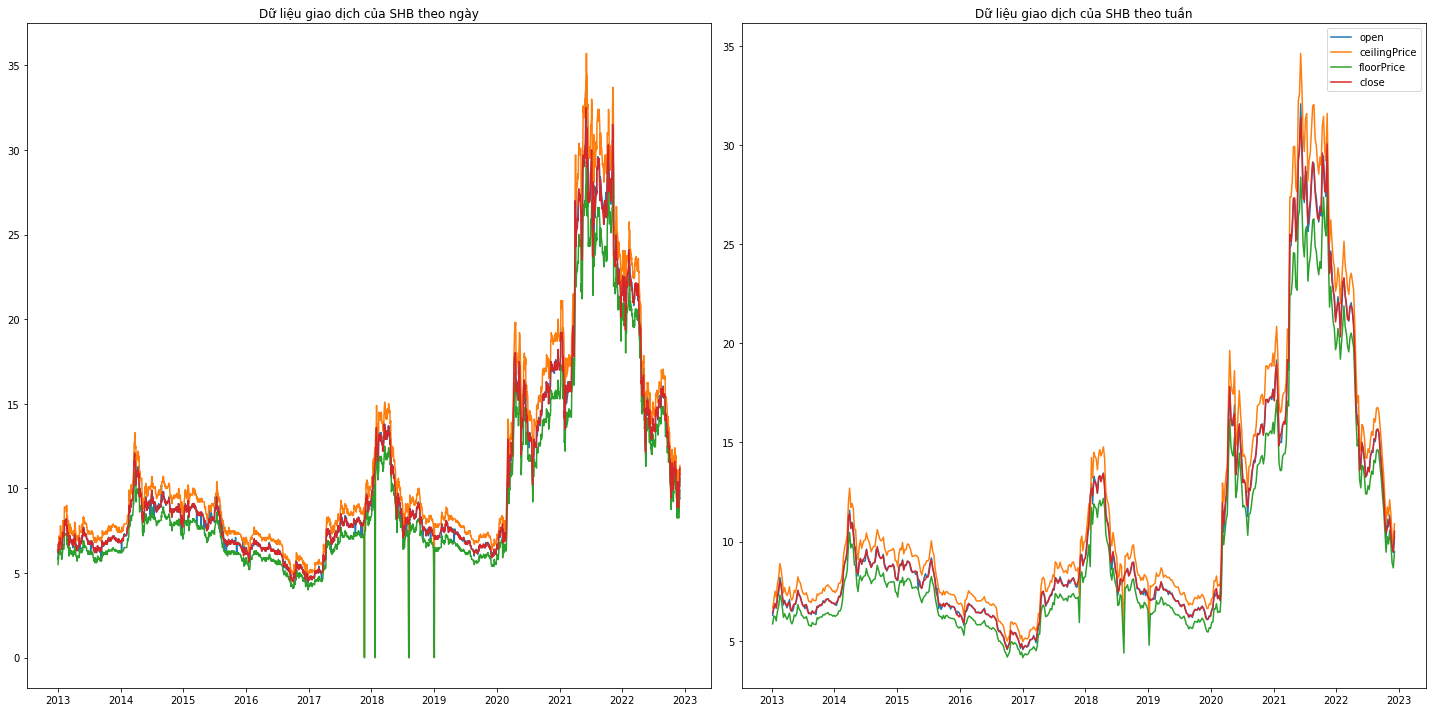

In [6]:
fig, axs = plt.subplots(1,2, figsize = (20,10)) #Tạo plot
axs[0].set_title(f"Dữ liệu giao dịch của {stockSymbol} theo ngày") #Tiêu đề cho plot 1
axs[1].set_title(f"Dữ liệu giao dịch của {stockSymbol} theo tuần") #Tiêu đề cho plot 2

dates = dataframe['date'] #Lấy cột date từ dataframe theo ngày
weeks = dataframe_w['date'] #Lấy cột date từ dataframe theo tuần
for feature in features[1:]:
    axs[0].plot(dates, dataframe[feature]) #Vẽ dường tương ứng với các feature được chọn trừ date theo ngày
    axs[1].plot(weeks, dataframe_w[feature]) #Vẽ dường tương ứng với các feature được chọn trừ date theo tuần

plt.legend(features[1:]) #Tạo chú thích
plt.tight_layout() #Giảm lề
plt.show() #In hình

# Hàm cho câu 3, 4, 5, 6


In [7]:
# Hàm này sẽ tách dataframe thành X, y
# Trong đó
# mỗi phần tử X là chứa {n_steps_in} ngày trước
# mỗi phần tử X là chứa ngày càng dự đoán
def split_sequences(sequences, n_steps_in):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + 1
		if out_end_ix > len(sequences):
			break

		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
# Hàm này sẽ thêm vào mảng dates {n} phần tử, {distance} mỗi phần tử thêm vào cách bao nhiêu ngày so với phần tử trước đó
# Ngoài ra nếu ngày đó là thứ 7 hay chủ nhật thì không được thêm vào dates
def dates_add(dates, n, distance=1):
  target = len(dates) + n
  tmp_date = dates.iloc[-1]
  while( len(dates) < target):
    tmp_date = tmp_date + pd.DateOffset(days=distance)

    if (tmp_date.weekday() < 5):
      dates = dates.append(pd.Series([tmp_date]))
  return dates

# Câu 3: Xây dựng và thực hiện dự đoán

## Dữ liệu theo ngày

### Mô hình RNN

Tiền xử lý

In [8]:
n_steps_in = 14 #Lấy {n_steps_in} ngày trước để dự đoán ngày hôm nay

dataset = dataframe[features[1:]].to_numpy() #Chuyển dataframe thành mảng
X, y = split_sequences(dataset, n_steps_in) #Chia dataset thành X và y theo {n_steps_in}

n_input = X.shape[1] * X.shape[2] #Tính chiều dài input
n_output = y.shape[1] * y.shape[2] #Tính chiều dài output

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=len(X)-n_steps_in,shuffle = False) #Chia dữ liệu tập train và test trong đó test chứa {n_steps_in} để thực hiện dự đoán

Xây dựng mô hình

In [9]:
model = Sequential() #Khởi tạo model
model.add(SimpleRNN(20)) #Thêm lớp SimpleRNN
model.add(Dense(n_output)) #Thêm lớp Dense với n_output là số lượng tham số đầu ra
model.compile(optimizer='adam', loss='mae')

Thực hiện huấn luyện mô hình

In [10]:
start_time = datetime.now()
model.fit(X_train, y_train, epochs=1000, shuffle=False, verbose=2)
print(f"Thời gian train: {(datetime.now()-start_time).total_seconds()} giây")

Epoch 1/1000
77/77 - 4s - loss: 9.0091 - 4s/epoch - 58ms/step
Epoch 2/1000
77/77 - 1s - loss: 7.2127 - 680ms/epoch - 9ms/step
Epoch 3/1000
77/77 - 1s - loss: 5.6105 - 666ms/epoch - 9ms/step
Epoch 4/1000
77/77 - 1s - loss: 4.4871 - 680ms/epoch - 9ms/step
Epoch 5/1000
77/77 - 1s - loss: 4.0204 - 694ms/epoch - 9ms/step
Epoch 6/1000
77/77 - 1s - loss: 3.8726 - 686ms/epoch - 9ms/step
Epoch 7/1000
77/77 - 1s - loss: 3.7179 - 668ms/epoch - 9ms/step
Epoch 8/1000
77/77 - 1s - loss: 3.5186 - 679ms/epoch - 9ms/step
Epoch 9/1000
77/77 - 1s - loss: 3.2965 - 680ms/epoch - 9ms/step
Epoch 10/1000
77/77 - 1s - loss: 3.1023 - 671ms/epoch - 9ms/step
Epoch 11/1000
77/77 - 1s - loss: 2.8981 - 688ms/epoch - 9ms/step
Epoch 12/1000
77/77 - 1s - loss: 2.7146 - 663ms/epoch - 9ms/step
Epoch 13/1000
77/77 - 1s - loss: 2.5346 - 681ms/epoch - 9ms/step
Epoch 14/1000
77/77 - 1s - loss: 2.4361 - 698ms/epoch - 9ms/step
Epoch 15/1000
77/77 - 1s - loss: 2.3369 - 685ms/epoch - 9ms/step
Epoch 16/1000
77/77 - 1s - loss: 2.2

Dự đoán tập test

In [11]:
test_predict = model.predict(X_test, verbose=0)
test_predict

array([[ 9.335608 , 10.204736 ,  8.3911915,  9.326518 ],
       [ 8.944372 ,  9.782854 ,  8.01688  ,  8.925619 ],
       [ 8.932069 ,  9.765952 ,  8.013373 ,  8.912502 ],
       [ 9.422749 , 10.30071  ,  8.470967 ,  9.410486 ],
       [ 9.6736765, 10.56713  ,  8.719958 ,  9.671775 ],
       [ 9.842227 , 10.749321 ,  8.8803215,  9.841955 ],
       [ 9.954163 , 10.867505 ,  8.99288  ,  9.959929 ],
       [ 8.800889 ,  9.627461 ,  7.8811502,  8.776747 ],
       [ 8.854066 ,  9.684729 ,  7.932973 ,  8.8332205],
       [ 8.947971 ,  9.786904 ,  8.020648 ,  8.926903 ],
       [ 9.328747 , 10.197467 ,  8.384969 ,  9.315176 ],
       [ 9.646922 , 10.538534 ,  8.693827 ,  9.643618 ],
       [ 9.670962 , 10.564049 ,  8.717467 ,  9.669487 ],
       [10.019834 , 10.93975  ,  9.052745 , 10.022402 ]], dtype=float32)

Vẽ hình dự đoán theo tập test

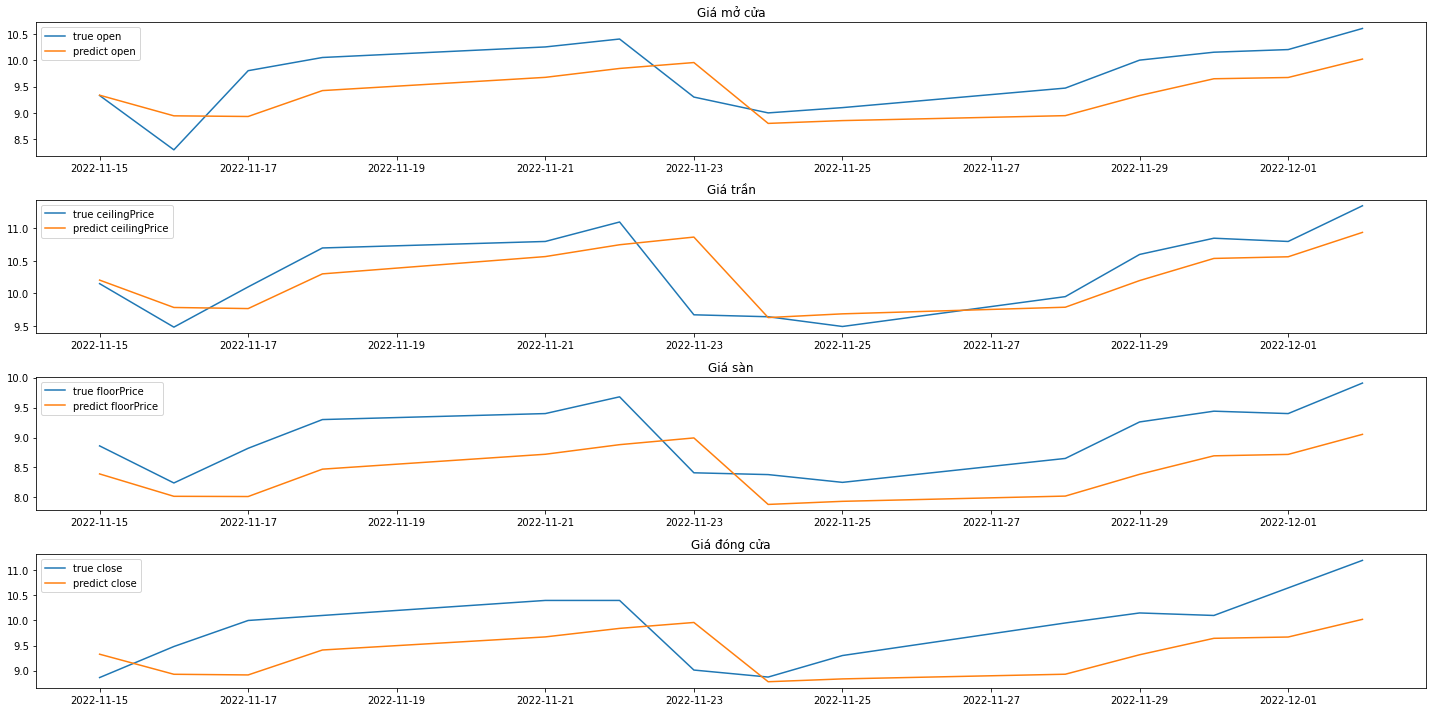

In [12]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe['date'][-(n_steps_in):] #Lấy cột date
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates, dataframe[feature][-(n_steps_in):]) #Vẽ dường thực tế
  axs[idx].plot(dates, test_predict[:,idx]) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

Dự đoán 14 ngày tiếp theo

In [13]:
predicts = list(dataframe[features[1:]][-14:].to_numpy()) #Lấy dữ liệu 14 ngày trước 

while(len(predicts) < 14+14): #Thực hiện vào lặp dự đoán 14 ngày tiếp theo
  X_predicts = np.array([predicts[-14:]]) #Lấy 14 ngày trước từ mảng predicts
  predict = model.predict(X_predicts, verbose=0) #Thực hiện dự đoán
  predicts.append(predict[0]) #Thêm dự đoán vào mảng predicts để tiếp tục dự đoán

predicts = np.array(predicts) #Chuyển predicts lại thành np array
predicts

array([[ 9.33      , 10.15      ,  8.86      ,  8.86      ],
       [ 8.3       ,  9.48      ,  8.24      ,  9.48      ],
       [ 9.8       , 10.1       ,  8.82      , 10.        ],
       [10.05      , 10.7       ,  9.3       , 10.1       ],
       [10.25      , 10.8       ,  9.4       , 10.4       ],
       [10.4       , 11.1       ,  9.68      , 10.4       ],
       [ 9.3       ,  9.67      ,  8.41      ,  9.01      ],
       [ 9.        ,  9.64      ,  8.38      ,  8.87      ],
       [ 9.1       ,  9.49      ,  8.25      ,  9.3       ],
       [ 9.47      ,  9.95      ,  8.65      ,  9.95      ],
       [10.        , 10.6       ,  9.26      , 10.15      ],
       [10.15      , 10.85      ,  9.44      , 10.1       ],
       [10.2       , 10.8       ,  9.4       , 10.65      ],
       [10.6       , 11.35      ,  9.91      , 11.2       ],
       [10.69703102, 11.66468525,  9.71242332, 10.71665287],
       [10.32527924, 11.26605415,  9.35152054, 10.33945274],
       [ 9.94354343, 10.

Vẽ hình dự đoán 14 ngày tiếp theo

In [14]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe['date'][-(n_steps_in):] #Lấy cột date
dates = dates_add(dates, 14) #Thêm vào mảng date 14 ngày
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates[:14], predicts[:14,idx]) #Vẽ dường thực tế
  axs[idx].plot(dates, np.concatenate((test_predict[:,idx], predicts[14:,idx]))) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

### Mô hình MLP

Tiền xử lý

In [15]:
n_steps_in = 14 #Lấy {n_steps_in} ngày trước để dự đoán ngày hôm nay

dataset = dataframe[features[1:]].to_numpy() #Chuyển dataframe thành mảng
X, y = split_sequences(dataset, n_steps_in) #Chia dataset thành X và y theo {n_steps_in}

n_input = X.shape[1] * X.shape[2] #Tính chiều dài input
X = X.reshape((X.shape[0], n_input)) #Chuyển X shape từ (?, {n_steps_in}, 4) thành (?, {n_steps_in}*4)
n_output = y.shape[1] * y.shape[2] #Tính chiều dài output
y = y.reshape((y.shape[0], n_output)) #Chuyển y shape từ (?, {n_steps_in}, 4) thành (?, {n_steps_in}*4)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=len(X)-n_steps_in,shuffle = False) #Chia dữ liệu tập train và test trong đó test chứa {n_steps_in} để thực hiện dự đoán

Xây dựng mô hình

In [16]:
model = Sequential() #Khởi tạo model
model.add(Dense(100, activation='relu')) #Thêm lớp Dense với n_input là số lương tham số đầu vào
model.add(Dense(n_output)) #Thêm lớp Dense với n_output là số lượng tham số đầu ra
model.compile(optimizer='adam', loss='mse')

Thực hiện huấn luyện mô hình

In [17]:
start_time = datetime.now() #Lưu thời gian bắt đầu trian
model.fit(X_train, y_train, epochs=1000, shuffle=False, verbose=2) #Train mô hình
print(f"Thời gian train: {(datetime.now()-start_time).total_seconds()} giây") #In thời gian train

Epoch 1/1000
77/77 - 0s - loss: 3.2867 - 450ms/epoch - 6ms/step
Epoch 2/1000
77/77 - 0s - loss: 1.0287 - 153ms/epoch - 2ms/step
Epoch 3/1000
77/77 - 0s - loss: 0.8798 - 140ms/epoch - 2ms/step
Epoch 4/1000
77/77 - 0s - loss: 0.7649 - 147ms/epoch - 2ms/step
Epoch 5/1000
77/77 - 0s - loss: 0.6831 - 143ms/epoch - 2ms/step
Epoch 6/1000
77/77 - 0s - loss: 0.6237 - 143ms/epoch - 2ms/step
Epoch 7/1000
77/77 - 0s - loss: 0.5805 - 139ms/epoch - 2ms/step
Epoch 8/1000
77/77 - 0s - loss: 0.5497 - 148ms/epoch - 2ms/step
Epoch 9/1000
77/77 - 0s - loss: 0.5288 - 137ms/epoch - 2ms/step
Epoch 10/1000
77/77 - 0s - loss: 0.4978 - 140ms/epoch - 2ms/step
Epoch 11/1000
77/77 - 0s - loss: 0.4851 - 134ms/epoch - 2ms/step
Epoch 12/1000
77/77 - 0s - loss: 0.4727 - 157ms/epoch - 2ms/step
Epoch 13/1000
77/77 - 0s - loss: 0.4637 - 140ms/epoch - 2ms/step
Epoch 14/1000
77/77 - 0s - loss: 0.4549 - 148ms/epoch - 2ms/step
Epoch 15/1000
77/77 - 0s - loss: 0.4479 - 150ms/epoch - 2ms/step
Epoch 16/1000
77/77 - 0s - loss: 0

Dự đoán tập test

In [18]:
test_predict = model.predict(X_test, verbose=0) #Thực hiện dự đoán tập test
test_predict #In dự đoán

array([[ 9.463766 , 10.3524   ,  8.594944 ,  9.569686 ],
       [ 8.914149 ,  9.742982 ,  8.110323 ,  9.02484  ],
       [ 9.222567 , 10.073167 ,  8.390298 ,  9.331977 ],
       [ 9.834696 , 10.733389 ,  8.942088 ,  9.941325 ],
       [ 9.966821 , 10.890833 ,  9.047565 , 10.073176 ],
       [10.197626 , 11.16684  ,  9.235893 , 10.30051  ],
       [10.251019 , 11.2434635,  9.27249  , 10.350537 ],
       [ 8.962863 ,  9.830175 ,  8.12614  ,  9.0719595],
       [ 8.768715 ,  9.627499 ,  7.947084 ,  8.877572 ],
       [ 9.13956  , 10.050297 ,  8.26711  ,  9.243254 ],
       [ 9.745947 , 10.710566 ,  8.811252 ,  9.845064 ],
       [10.10608  , 11.117134 ,  9.115313 , 10.206408 ],
       [ 9.991514 , 10.984565 ,  9.016231 , 10.094609 ],
       [10.376944 , 11.441002 ,  9.333172 , 10.475137 ]], dtype=float32)

Vẽ hình dự đoán theo tập test

In [19]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe['date'][-(n_steps_in):] #Lấy cột date
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates, dataframe[feature][-(n_steps_in):]) #Vẽ dường thực tế
  axs[idx].plot(dates, test_predict[:,idx]) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

Dự đoán 14 ngày tiếp theo

In [20]:
predicts = list(dataframe[features[1:]][-14:].to_numpy()) #Lấy dữ liệu 14 ngày trước 

while(len(predicts) < 14+14): #Thực hiện vào lặp dự đoán 14 ngày tiếp theo
  X_predicts = np.array(predicts[-14:]) #Lấy 14 ngày trước từ mảng predicts
  X_predicts = X_predicts.reshape((1, n_input)) #Chuyển từ dạng (?, {n_steps_in}, 6) sang (?, {n_steps_in}*6)

  predict = model.predict(X_predicts, verbose=0) #Thực hiện dự đoán
  predicts.append(predict[0]) #Thêm dự đoán vào mảng predicts để tiếp tục dự đoán

predicts = np.array(predicts) #Chuyển predicts lại thành np array
predicts[-14:] #In dự đoán 14 ngày tiếp theo

array([[10.95440102, 12.09004021,  9.84248447, 11.04283333],
       [10.98998642, 12.14102936,  9.87000561, 11.07431602],
       [11.03400803, 12.17857742,  9.91992474, 11.11720085],
       [11.05456829, 12.19723892,  9.94289017, 11.13684368],
       [11.07791328, 12.22616768,  9.96150112, 11.15956688],
       [11.0443716 , 12.19855881,  9.92442894, 11.12577248],
       [11.14714336, 12.30003071, 10.02395248, 11.22888374],
       [11.28020859, 12.43396282, 10.14998817, 11.36275005],
       [11.43844318, 12.58625603, 10.30620766, 11.5217905 ],
       [11.58232403, 12.73849297, 10.44098568, 11.66350174],
       [11.71464443, 12.88638401, 10.55829239, 11.79366302],
       [11.8421936 , 13.02422142, 10.67542744, 11.9191761 ],
       [12.02390957, 13.21760178, 10.84432793, 12.09836006],
       [12.18541241, 13.39652348, 10.98944473, 12.25689316]])

Vẽ hình dự đoán 14 ngày tiếp theo

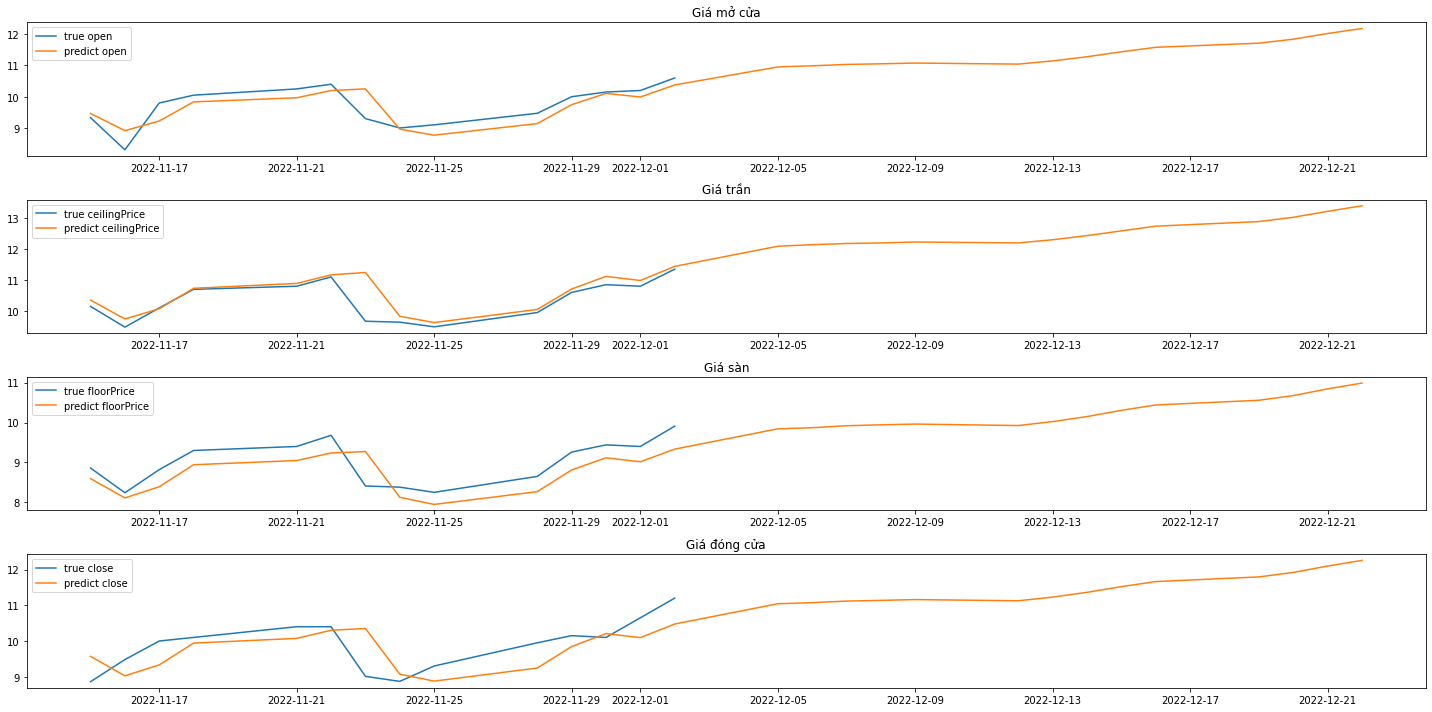

In [21]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe['date'][-(n_steps_in):] #Lấy cột date
dates = dates_add(dates, 14) #Thêm vào mảng date 14 ngày
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates[:14], predicts[:14,idx]) #Vẽ dường thực tế
  axs[idx].plot(dates, np.concatenate((test_predict[:,idx], predicts[14:,idx]))) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

## Dữ liệu theo tuần

### Mô hình RNN

Tiền xử lý

In [22]:
n_steps_in = 7 #Lấy {n_steps_in} tuần trước để dự đoán tuần này

dataset = dataframe_w[features[1:]].to_numpy() #Chuyển dataframe tuần thành mảng
X, y = split_sequences(dataset, n_steps_in) #Chia dataset thành X và y theo {n_steps_in}

n_input = X.shape[1] * X.shape[2] #Tính chiều dài input
n_output = y.shape[1] * y.shape[2] #Tính chiều dài output

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=len(X)-n_steps_in,shuffle = False) #Chia dữ liệu tập train và test trong đó test chứa {n_steps_in} để thực hiện dự đoán

Xây dựng mô hình

In [23]:
model = Sequential() #Khởi tạo model
model.add(SimpleRNN(20)) #Thêm lớp SimpleRNN
model.add(Dense(n_output)) #Thêm lớp Dense với n_output là số lượng tham số đầu ra
model.compile(optimizer='adam', loss='mae')

Thực hiện huấn luyện mô hình

In [24]:
start_time = datetime.now() #Lưu thời gian bắt đầu train
model.fit(X_train, y_train, epochs=1000, shuffle=False, verbose=2) #Train mô hình
print(f"Thời gian train: {(datetime.now()-start_time).total_seconds()} giây") #In ra thời gian train

Epoch 1/1000
16/16 - 1s - loss: 11.1367 - 813ms/epoch - 51ms/step
Epoch 2/1000
16/16 - 0s - loss: 10.5442 - 92ms/epoch - 6ms/step
Epoch 3/1000
16/16 - 0s - loss: 10.0982 - 88ms/epoch - 6ms/step
Epoch 4/1000
16/16 - 0s - loss: 9.6365 - 94ms/epoch - 6ms/step
Epoch 5/1000
16/16 - 0s - loss: 9.0740 - 99ms/epoch - 6ms/step
Epoch 6/1000
16/16 - 0s - loss: 8.5731 - 110ms/epoch - 7ms/step
Epoch 7/1000
16/16 - 0s - loss: 8.0226 - 88ms/epoch - 5ms/step
Epoch 8/1000
16/16 - 0s - loss: 7.5343 - 101ms/epoch - 6ms/step
Epoch 9/1000
16/16 - 0s - loss: 7.1631 - 94ms/epoch - 6ms/step
Epoch 10/1000
16/16 - 0s - loss: 6.7670 - 103ms/epoch - 6ms/step
Epoch 11/1000
16/16 - 0s - loss: 6.3403 - 94ms/epoch - 6ms/step
Epoch 12/1000
16/16 - 0s - loss: 6.0129 - 105ms/epoch - 7ms/step
Epoch 13/1000
16/16 - 0s - loss: 5.7149 - 88ms/epoch - 6ms/step
Epoch 14/1000
16/16 - 0s - loss: 5.4408 - 95ms/epoch - 6ms/step
Epoch 15/1000
16/16 - 0s - loss: 5.1998 - 94ms/epoch - 6ms/step
Epoch 16/1000
16/16 - 0s - loss: 4.9924 

Dự đoán tập test

In [25]:
test_predict = model.predict(X_test, verbose=0) #Thực hiện dự đoán
test_predict #In kết quả dự đoán

array([[13.166353 , 14.234918 , 12.172365 , 13.169302 ],
       [12.620719 , 13.703662 , 11.693433 , 12.662577 ],
       [12.714649 , 13.799079 , 11.757057 , 12.696829 ],
       [11.438673 , 12.393231 , 10.527483 , 11.402304 ],
       [ 8.655152 ,  9.489037 ,  7.865197 ,  8.6492815],
       [ 9.165408 ,  9.910701 ,  8.301517 ,  9.113956 ],
       [ 8.627815 ,  9.347812 ,  7.792884 ,  8.616944 ]], dtype=float32)

Vẽ hình dự đoán theo tập test

In [26]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe_w['date'][-(n_steps_in):] #Lấy cột date
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates, dataframe_w[feature][-(n_steps_in):]) #Vẽ dường thực tế
  axs[idx].plot(dates, test_predict[:,idx]) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

Dự đoán 7 tuần tiếp theo

In [27]:
predicts = list(dataframe[features[1:]][-7:].to_numpy()) #Lấy dữ liệu 7 tuần trước 

while(len(predicts) < 7+7): #Thực hiện vào lặp dự đoán 7 tuần tiếp theo
  X_predicts = np.array([predicts[-7:]]) #Lấy 7 tuần trước từ mảng predicts
  predict = model.predict(X_predicts, verbose=0) #Thực hiện dự đoán
  predicts.append(predict[0]) #Thêm dự đoán vào mảng predicts để tiếp tục dự đoán

predicts = np.array(predicts) #Chuyển predicts lại thành np array
predicts[7:] #In dự đoán

array([[ 9.4768219 , 10.22569752,  8.60660267,  9.43737984],
       [ 7.38250875,  8.1548872 ,  6.66412735,  7.42080688],
       [ 7.17496157,  7.83319998,  6.46058321,  7.19534016],
       [ 7.20218277,  7.88077497,  6.53446865,  7.22684574],
       [ 7.20833349,  7.94480276,  6.5522995 ,  7.2355938 ],
       [ 7.41913271,  8.12222004,  6.75276995,  7.42618942],
       [ 7.67241716,  8.37410069,  6.97004175,  7.67344761]])

Vẽ hình dự đoán 7 tuần tiếp theo

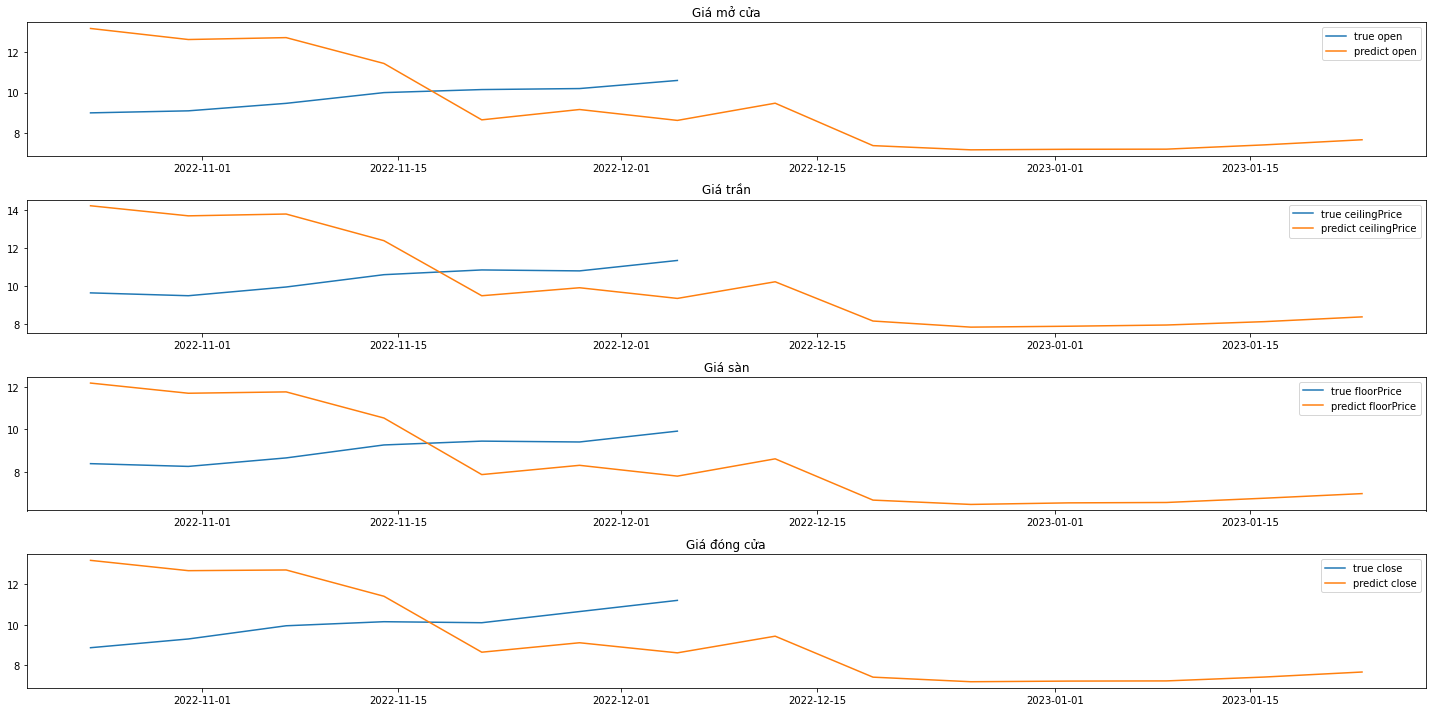

In [28]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe_w['date'][-(n_steps_in):] #Lấy cột date
dates = dates_add(dates, 7, distance=7) #Thêm vào mảng date 7 tuần
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates[:7], predicts[:7,idx]) #Vẽ dường thực tế
  axs[idx].plot(dates, np.concatenate((test_predict[:,idx], predicts[7:,idx]))) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

### Mô hình MLP

Tiền xử lý

In [29]:
n_steps_in = 7 #Lấy {n_steps_in} ngày trước để dự đoán ngày hôm nay

dataset = dataframe_w[features[1:]].to_numpy() #Chuyển dataframe tuần thành mảng
X, y = split_sequences(dataset, n_steps_in) #Chia dataset thành X và y theo {n_steps_in}

n_input = X.shape[1] * X.shape[2] #Tính chiều dài input
X = X.reshape((X.shape[0], n_input)) #Chuyển X shape từ (?, {n_steps_in}, 4) thành (?, {n_steps_in}*4)
n_output = y.shape[1] * y.shape[2] #Tính chiều dài output
y = y.reshape((y.shape[0], n_output)) #Chuyển y shape từ (?, {n_steps_in}, 4) thành (?, {n_steps_in}*4)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=len(X)-n_steps_in,shuffle = False) #Chia dữ liệu tập train và test trong đó test chứa {n_steps_in} để thực hiện dự đoán

Xây dựng mô hình

In [30]:
model = Sequential() #Khởi tạo model
model.add(Dense(100, activation='relu', input_dim=n_input)) #Thêm lớp Dense với n_input là số lương tham số đầu vào
model.add(Dense(n_output)) #Thêm lớp Dense với n_output là số lượng tham số đầu ra
model.compile(optimizer='adam', loss='mse')

Thực hiện huấn luyện mô hình

In [31]:
start_time = datetime.now() #Lưu thời gian bắt đầu train
model.fit(X_train, y_train, epochs=1000, shuffle=False, verbose=2) #Train mô hình
print(f"Thời gian train: {(datetime.now()-start_time).total_seconds()} giây") #In thời gian train

Epoch 1/1000
16/16 - 0s - loss: 15.2782 - 299ms/epoch - 19ms/step
Epoch 2/1000
16/16 - 0s - loss: 2.9969 - 32ms/epoch - 2ms/step
Epoch 3/1000
16/16 - 0s - loss: 2.3291 - 32ms/epoch - 2ms/step
Epoch 4/1000
16/16 - 0s - loss: 2.5198 - 32ms/epoch - 2ms/step
Epoch 5/1000
16/16 - 0s - loss: 2.1460 - 30ms/epoch - 2ms/step
Epoch 6/1000
16/16 - 0s - loss: 2.3070 - 42ms/epoch - 3ms/step
Epoch 7/1000
16/16 - 0s - loss: 1.8695 - 31ms/epoch - 2ms/step
Epoch 8/1000
16/16 - 0s - loss: 2.0253 - 31ms/epoch - 2ms/step
Epoch 9/1000
16/16 - 0s - loss: 1.6403 - 32ms/epoch - 2ms/step
Epoch 10/1000
16/16 - 0s - loss: 1.8123 - 33ms/epoch - 2ms/step
Epoch 11/1000
16/16 - 0s - loss: 1.4971 - 30ms/epoch - 2ms/step
Epoch 12/1000
16/16 - 0s - loss: 1.6279 - 52ms/epoch - 3ms/step
Epoch 13/1000
16/16 - 0s - loss: 1.3762 - 31ms/epoch - 2ms/step
Epoch 14/1000
16/16 - 0s - loss: 1.4332 - 32ms/epoch - 2ms/step
Epoch 15/1000
16/16 - 0s - loss: 1.2767 - 34ms/epoch - 2ms/step
Epoch 16/1000
16/16 - 0s - loss: 1.2755 - 32ms

Dự đoán tập test

In [32]:
test_predict = model.predict(X_test, verbose=0) #Thực hiện dự đoán tập test
test_predict #In dự đoán

array([[10.805013 , 11.6005535,  9.986068 , 10.846293 ],
       [10.728724 , 11.528503 ,  9.905677 , 10.7456045],
       [10.683515 , 11.503538 ,  9.839548 , 10.73882  ],
       [11.125329 , 12.063883 , 10.182992 , 11.153049 ],
       [10.469386 , 11.376196 ,  9.535843 , 10.52077  ],
       [ 9.994599 , 10.795168 ,  9.099036 ,  9.964972 ],
       [ 9.752858 , 10.558169 ,  8.909048 ,  9.717722 ]], dtype=float32)

Vẽ hình dự đoán theo tập test

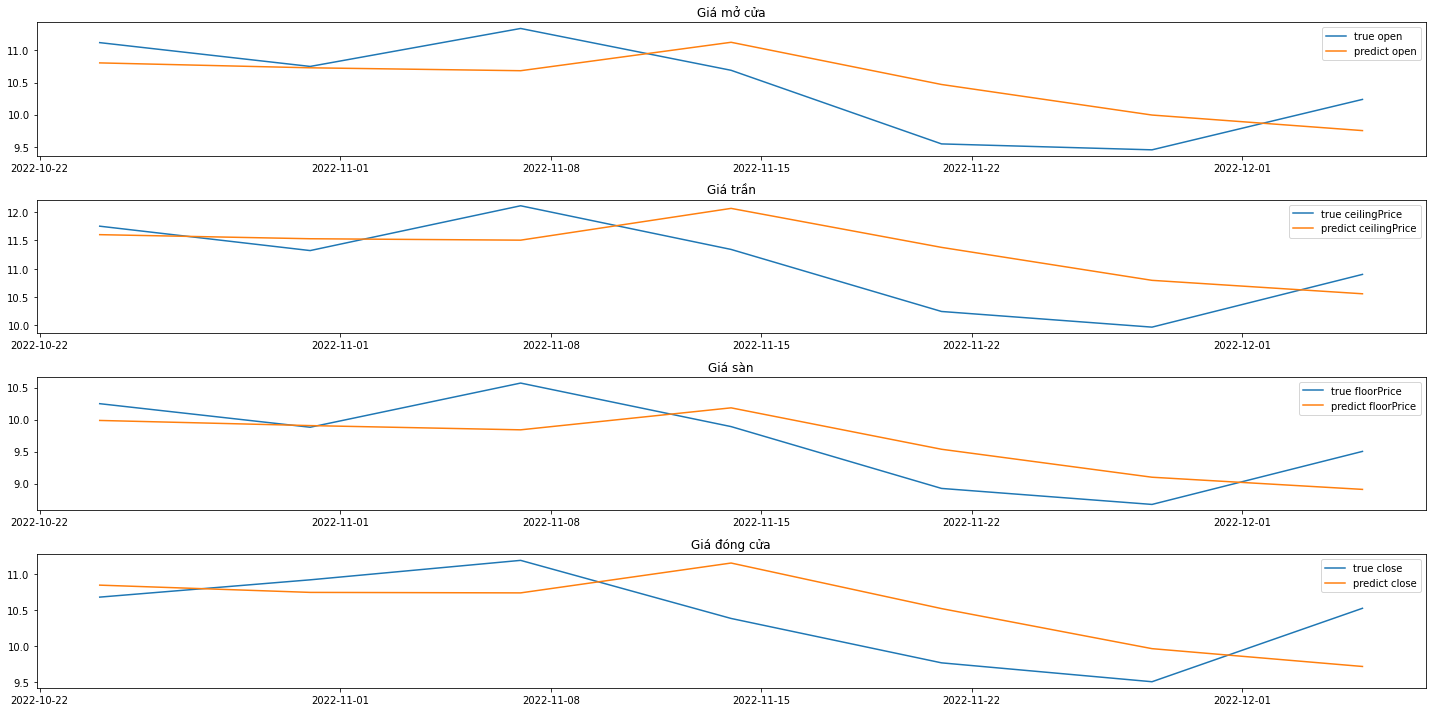

In [33]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe_w['date'][-(n_steps_in):] #Lấy cột date
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates, dataframe_w[feature][-(n_steps_in):]) #Vẽ dường thực tế
  axs[idx].plot(dates, test_predict[:,idx]) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

Dự đoán 7 tuần tiếp theo

In [34]:
predicts = list(dataframe[features[1:]][-7:].to_numpy()) #Lấy dữ liệu 7 tuần trước 

while(len(predicts) < 7+7): #Thực hiện vào lặp dự đoán 7 tuần tiếp theo
  X_predicts = np.array(predicts[-7:]) #Lấy 7 ngày trước từ mảng predicts
  X_predicts = X_predicts.reshape((1, n_input)) #Chuyển từ dạng (?, {n_steps_in}, 4) sang (?, {n_steps_in}*4)

  predict = model.predict(X_predicts, verbose=0) #Thực hiện dự đoán
  predicts.append(predict[0]) #Thêm dự đoán vào mảng predicts để tiếp tục dự đoán

predicts = np.array(predicts) #Chuyển predicts lại thành np array
predicts

array([[ 9.        ,  9.64      ,  8.38      ,  8.87      ],
       [ 9.1       ,  9.49      ,  8.25      ,  9.3       ],
       [ 9.47      ,  9.95      ,  8.65      ,  9.95      ],
       [10.        , 10.6       ,  9.26      , 10.15      ],
       [10.15      , 10.85      ,  9.44      , 10.1       ],
       [10.2       , 10.8       ,  9.4       , 10.65      ],
       [10.6       , 11.35      ,  9.91      , 11.2       ],
       [11.05879116, 12.0537653 , 10.01384068, 11.05151081],
       [11.15125179, 12.16910744, 10.10504532, 11.14205647],
       [11.38778687, 12.43826485, 10.32202721, 11.40460968],
       [11.52903748, 12.57646751, 10.43552971, 11.54227829],
       [11.68912601, 12.72739601, 10.57352066, 11.68402481],
       [11.90087128, 12.9739809 , 10.77777195, 11.88388348],
       [12.04119396, 13.13232231, 10.91972733, 12.06327915]])

Vẽ hình dự đoán 14 ngày tiếp theo

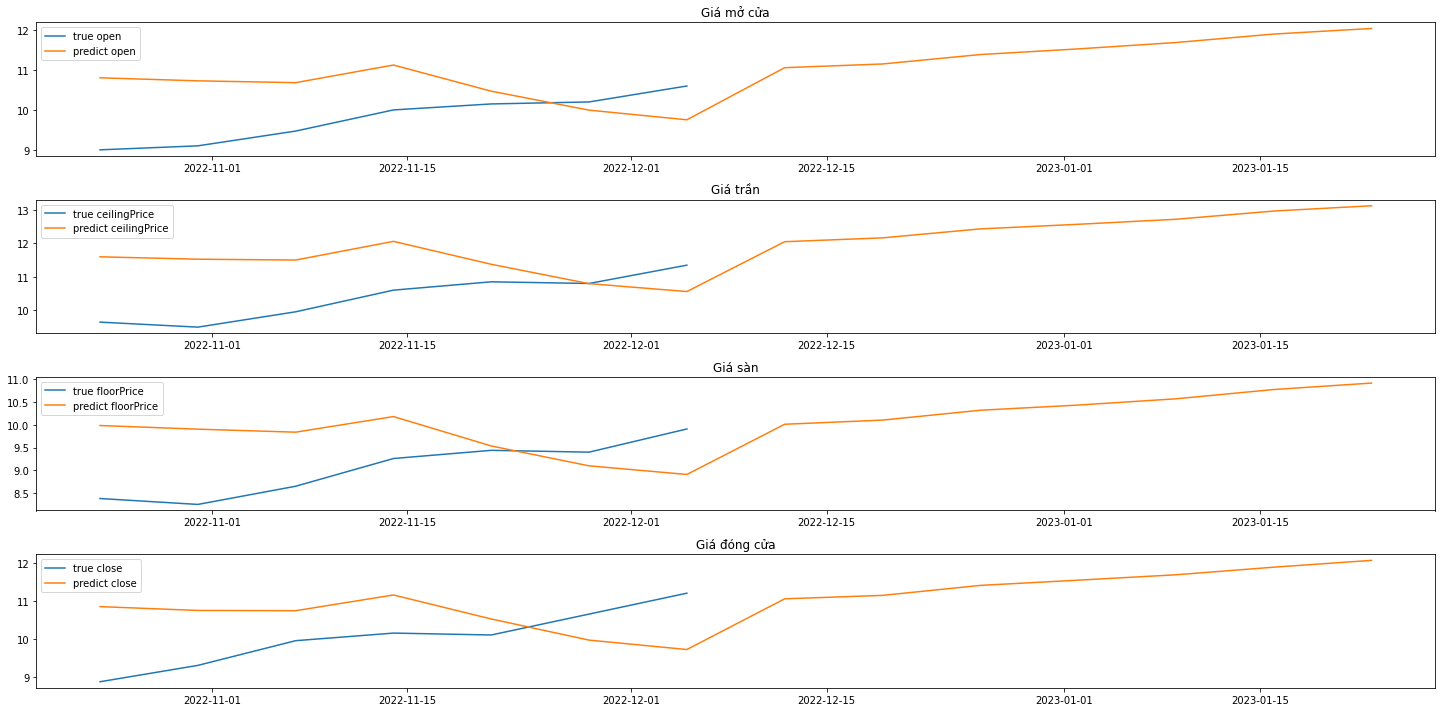

In [35]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe_w['date'][-(n_steps_in):] #Lấy cột date
dates = dates_add(dates, 7, distance=7) #Thêm vào mảng date 7 tuần
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates[:7], predicts[:7,idx]) #Vẽ dường thực tế
  axs[idx].plot(dates, np.concatenate((test_predict[:,idx], predicts[7:,idx]))) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

#Câu 4: Chống Overfitting

## Dữ liệu theo ngày

### Mô hình RNN

Tiền xử lý

In [36]:
n_steps_in = 14 #Lấy {n_steps_in} ngày trước để dự đoán ngày hôm nay

dataset = dataframe[features[1:]].to_numpy() #Chuyển dataframe thành mảng
X, y = split_sequences(dataset, n_steps_in) #Chia dataset thành X và y theo {n_steps_in}

n_input = X.shape[1] * X.shape[2] #Tính chiều dài input
n_output = y.shape[1] * y.shape[2] #Tính chiều dài output

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=len(X)-n_steps_in,shuffle = False) #Chia dữ liệu tập train và test trong đó test chứa {n_steps_in} để thực hiện dự đoán

Xây dựng mô hình

In [37]:
model = Sequential() #Khởi tạo model
model.add(SimpleRNN(20,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))) #Thêm lớp SimpleRNN với regularizer
model.add(Dropout(0.1)) #Thêm lớp Drop Out
model.add(Dense(n_output)) #Thêm lớp Dense với n_output là số lượng tham số đầu ra
model.compile(optimizer='adam', loss='mae')

Thực hiện huấn luyện mô hình

In [38]:
callback = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True) #EarlyStop nếu 50 epoch không thay đổi loss trả về mô hình với loss thấp nhất

start_time = datetime.now() #Lưu thời gian bắt đầu train
model.fit(X_train, y_train, epochs=1000, shuffle=False, verbose=2, callbacks=[callback]) #Train mô hình
print(f"Thời gian train: {(datetime.now()-start_time).total_seconds()} giây") #In thời gian train

Epoch 1/1000
77/77 - 2s - loss: 9.3284 - 2s/epoch - 21ms/step
Epoch 2/1000
77/77 - 1s - loss: 7.4682 - 737ms/epoch - 10ms/step
Epoch 3/1000
77/77 - 1s - loss: 5.8331 - 776ms/epoch - 10ms/step
Epoch 4/1000
77/77 - 1s - loss: 4.6523 - 736ms/epoch - 10ms/step
Epoch 5/1000
77/77 - 1s - loss: 4.2136 - 738ms/epoch - 10ms/step
Epoch 6/1000
77/77 - 1s - loss: 3.9990 - 756ms/epoch - 10ms/step
Epoch 7/1000
77/77 - 1s - loss: 3.7783 - 744ms/epoch - 10ms/step
Epoch 8/1000
77/77 - 1s - loss: 3.5484 - 706ms/epoch - 9ms/step
Epoch 9/1000
77/77 - 1s - loss: 3.3701 - 759ms/epoch - 10ms/step
Epoch 10/1000
77/77 - 1s - loss: 3.1659 - 744ms/epoch - 10ms/step
Epoch 11/1000
77/77 - 1s - loss: 3.0265 - 758ms/epoch - 10ms/step
Epoch 12/1000
77/77 - 1s - loss: 2.8648 - 739ms/epoch - 10ms/step
Epoch 13/1000
77/77 - 1s - loss: 2.7331 - 735ms/epoch - 10ms/step
Epoch 14/1000
77/77 - 1s - loss: 2.6324 - 725ms/epoch - 9ms/step
Epoch 15/1000
77/77 - 1s - loss: 2.5049 - 726ms/epoch - 9ms/step
Epoch 16/1000
77/77 - 1s 

Dự đoán tập test

In [39]:
test_predict = model.predict(X_test, verbose=0) #Dự đoán tập test
test_predict #In dự đoán

array([[ 9.720109 , 10.536849 ,  8.859597 ,  9.645501 ],
       [ 9.044594 ,  9.806981 ,  8.243713 ,  8.967896 ],
       [ 9.376558 , 10.132912 ,  8.570039 ,  9.33883  ],
       [10.087915 , 10.90701  ,  9.20907  , 10.034557 ],
       [10.292296 , 11.134182 ,  9.39585  , 10.231651 ],
       [10.463275 , 11.312381 ,  9.559226 , 10.404989 ],
       [10.319603 , 11.157878 ,  9.427149 , 10.252453 ],
       [ 7.408619 ,  7.984544 ,  6.795785 ,  7.354541 ],
       [ 8.63985  ,  9.378978 ,  7.8579865,  8.575413 ],
       [10.2688   , 11.139386 ,  9.341504 , 10.21751  ],
       [10.513171 , 11.362256 ,  9.602704 , 10.469268 ],
       [ 9.91897  , 10.704288 ,  9.078058 ,  9.860361 ],
       [ 9.72906  , 10.519115 ,  8.89091  ,  9.663606 ],
       [10.631324 , 11.496952 ,  9.707564 , 10.577055 ]], dtype=float32)

Vẽ hình dự đoán theo tập test

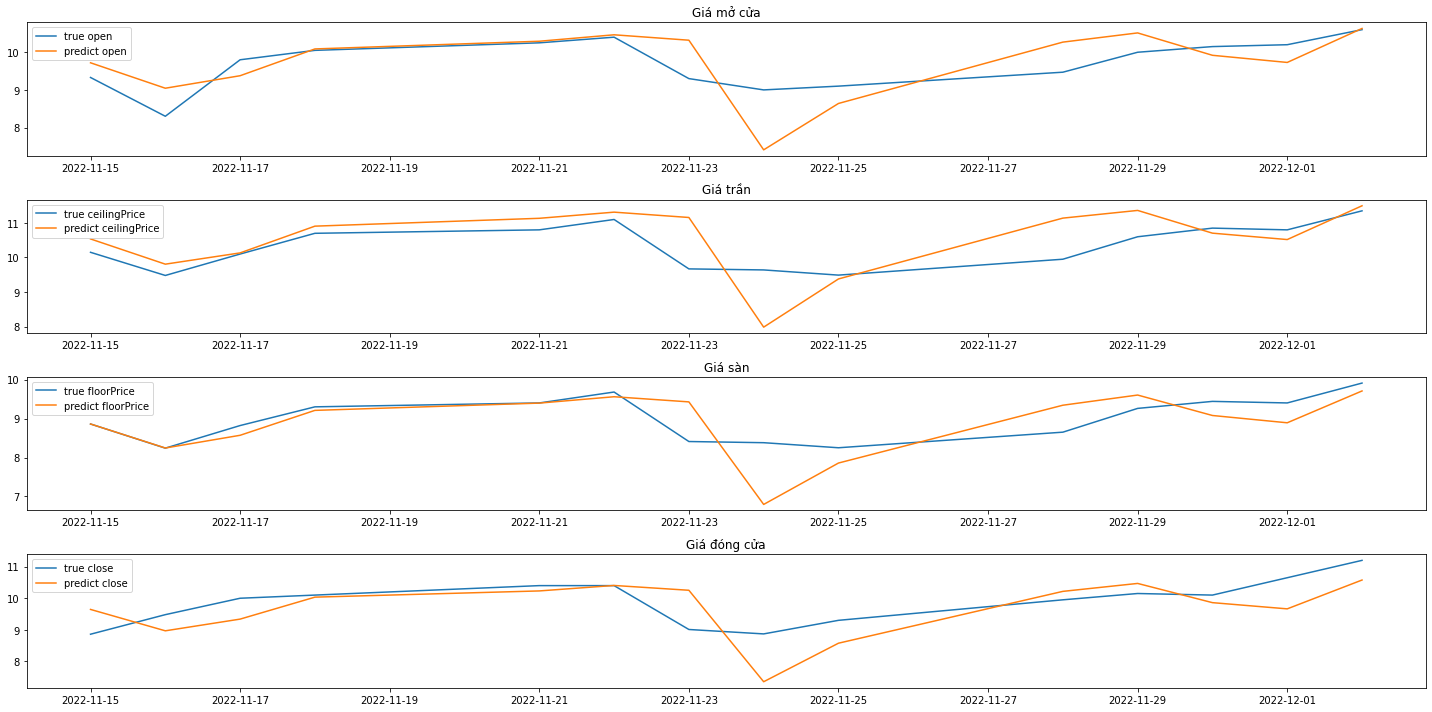

In [40]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe['date'][-(n_steps_in):] #Lấy cột date
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates, dataframe[feature][-(n_steps_in):]) #Vẽ dường thực tế
  axs[idx].plot(dates, test_predict[:,idx]) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

Dự đoán 14 ngày tiếp theo

In [41]:
predicts = list(dataframe[features[1:]][-14:].to_numpy()) #Lấy dữ liệu 14 ngày trước 

while(len(predicts) < 14+14): #Thực hiện vào lặp dự đoán 14 ngày tiếp theo
  X_predicts = np.array([predicts[-14:]]) #Lấy 14 ngày trước từ mảng predicts
  predict = model.predict(X_predicts, verbose=0) #Thực hiện dự đoán
  predicts.append(predict[0]) #Thêm dự đoán vào mảng predicts để tiếp tục dự đoán

predicts = np.array(predicts) #Chuyển predicts lại thành np array
predicts[-14:] #In dự đoán 14 ngày tiếp theo

array([[11.27550697, 12.18093204, 10.30430698, 11.21831799],
       [11.8522377 , 12.84950733, 10.81075668, 11.80047607],
       [13.14847183, 14.27046204, 11.98222446, 13.09640026],
       [15.30457401, 16.61948395, 13.93792057, 15.24890518],
       [18.28026199, 19.85617065, 16.64317322, 18.22127533],
       [21.52814293, 23.38949585, 19.59649467, 21.46901321],
       [24.31389046, 26.42434692, 22.12687111, 24.25977707],
       [26.1973629 , 28.48064995, 23.83430481, 26.1500473 ],
       [27.26906967, 29.65351868, 24.80330086, 27.22681808],
       [27.82661247, 30.26490021, 25.30622101, 27.78726578],
       [28.10660362, 30.57234001, 25.55836105, 28.06875992],
       [28.24556923, 30.72504997, 25.68338013, 28.20847702],
       [28.3142395 , 30.80054092, 25.74512482, 28.27751541],
       [28.34811592, 30.83779144, 25.77557755, 28.31157684]])

Vẽ hình dự đoán 14 ngày tiếp theo

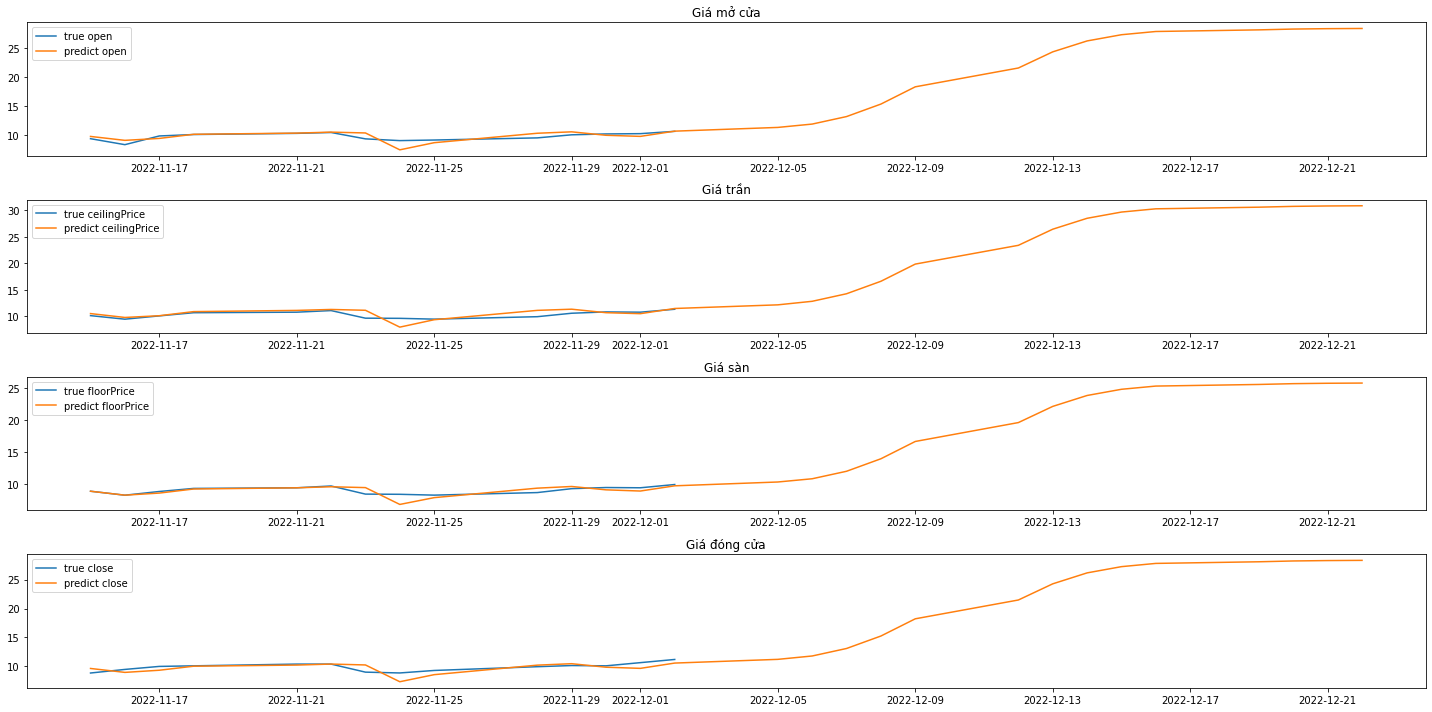

In [42]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe['date'][-(n_steps_in):] #Lấy cột date
dates = dates_add(dates, 14) #Thêm vào mảng date 14 ngày
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates[:14], predicts[:14,idx]) #Vẽ dường thực tế
  axs[idx].plot(dates, np.concatenate((test_predict[:,idx], predicts[14:,idx]))) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

### Mô hình MLP

Tiền xử lý

In [43]:
n_steps_in = 14 #Lấy {n_steps_in} ngày trước để dự đoán ngày hôm nay

dataset = dataframe[features[1:]].to_numpy() #Chuyển dataframe thành mảng
X, y = split_sequences(dataset, n_steps_in) #Chia dataset thành X và y theo {n_steps_in}

n_input = X.shape[1] * X.shape[2] #Tính chiều dài input
X = X.reshape((X.shape[0], n_input)) #Chuyển X shape từ (?, 7, 4) thành (?, 28)
n_output = y.shape[1] * y.shape[2] #Tính chiều dài output
y = y.reshape((y.shape[0], n_output)) #Chuyển y shape từ (?, 7, 4) thành (?, 28)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=len(X)-n_steps_in,shuffle = False) #Chia dữ liệu tập train và test trong đó test chứa {n_steps_in} để thực hiện dự đoán

Xây dựng mô hình

In [44]:
model = Sequential() #Khởi tạo model
model.add(Dense(100, activation='relu', input_dim=n_input, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))) #Thêm lớp Dense với n_input là số lương tham số đầu vào và regularizer
model.add(Dropout(0.01)) #Thêm lớp Drop Out
model.add(Dense(n_output)) #Thêm lớp Dense với n_output là số lượng tham số đầu ra
model.compile(optimizer='adam', loss='mse')

Thực hiện huấn luyện mô hình

In [45]:
callback = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True) #EarlyStop nếu 50 epoch không thay đổi loss trả về mô hình với loss thấp nhất

start_time = datetime.now() #Lưu thời gian bắt đầu train
model.fit(X_train, y_train, epochs=1000, shuffle=False, verbose=2, callbacks=[callback]) #Train mô hình
print(f"Thời gian train: {(datetime.now()-start_time).total_seconds()} giây") #In ra thời gian train

Epoch 1/1000
77/77 - 1s - loss: 5.5653 - 502ms/epoch - 7ms/step
Epoch 2/1000
77/77 - 0s - loss: 2.2624 - 153ms/epoch - 2ms/step
Epoch 3/1000
77/77 - 0s - loss: 2.0510 - 153ms/epoch - 2ms/step
Epoch 4/1000
77/77 - 0s - loss: 1.8899 - 164ms/epoch - 2ms/step
Epoch 5/1000
77/77 - 0s - loss: 1.6966 - 152ms/epoch - 2ms/step
Epoch 6/1000
77/77 - 0s - loss: 1.4077 - 162ms/epoch - 2ms/step
Epoch 7/1000
77/77 - 0s - loss: 1.3338 - 149ms/epoch - 2ms/step
Epoch 8/1000
77/77 - 0s - loss: 1.2235 - 164ms/epoch - 2ms/step
Epoch 9/1000
77/77 - 0s - loss: 1.1794 - 151ms/epoch - 2ms/step
Epoch 10/1000
77/77 - 0s - loss: 1.0300 - 160ms/epoch - 2ms/step
Epoch 11/1000
77/77 - 0s - loss: 1.0185 - 156ms/epoch - 2ms/step
Epoch 12/1000
77/77 - 0s - loss: 0.9801 - 151ms/epoch - 2ms/step
Epoch 13/1000
77/77 - 0s - loss: 1.0092 - 152ms/epoch - 2ms/step
Epoch 14/1000
77/77 - 0s - loss: 0.9379 - 150ms/epoch - 2ms/step
Epoch 15/1000
77/77 - 0s - loss: 0.9224 - 150ms/epoch - 2ms/step
Epoch 16/1000
77/77 - 0s - loss: 0

Dự đoán tập test

In [46]:
test_predict = model.predict(X_test, verbose=0)
test_predict

array([[ 9.72335  , 10.260787 ,  8.696845 ,  9.671335 ],
       [ 9.20701  ,  9.698661 ,  8.270541 ,  9.129596 ],
       [ 9.039948 ,  9.576868 ,  8.184688 ,  9.023102 ],
       [ 9.879167 , 10.362108 ,  8.903529 ,  9.797006 ],
       [10.195485 , 10.759895 ,  9.264481 , 10.112138 ],
       [10.352827 , 10.924693 ,  9.385653 , 10.299394 ],
       [10.5238285, 11.106911 ,  9.4795885, 10.450029 ],
       [ 9.375741 ,  9.887169 ,  8.423458 ,  9.299621 ],
       [ 8.954612 ,  9.517138 ,  8.077077 ,  8.910198 ],
       [ 9.168755 ,  9.675928 ,  8.236009 ,  9.08092  ],
       [ 9.765377 , 10.371894 ,  8.884315 ,  9.685975 ],
       [10.157001 , 10.771561 ,  9.166129 , 10.088414 ],
       [10.321102 , 10.897982 ,  9.225182 , 10.23641  ],
       [10.478382 , 11.085517 ,  9.377271 , 10.349561 ]], dtype=float32)

Vẽ hình dự đoán theo tập test

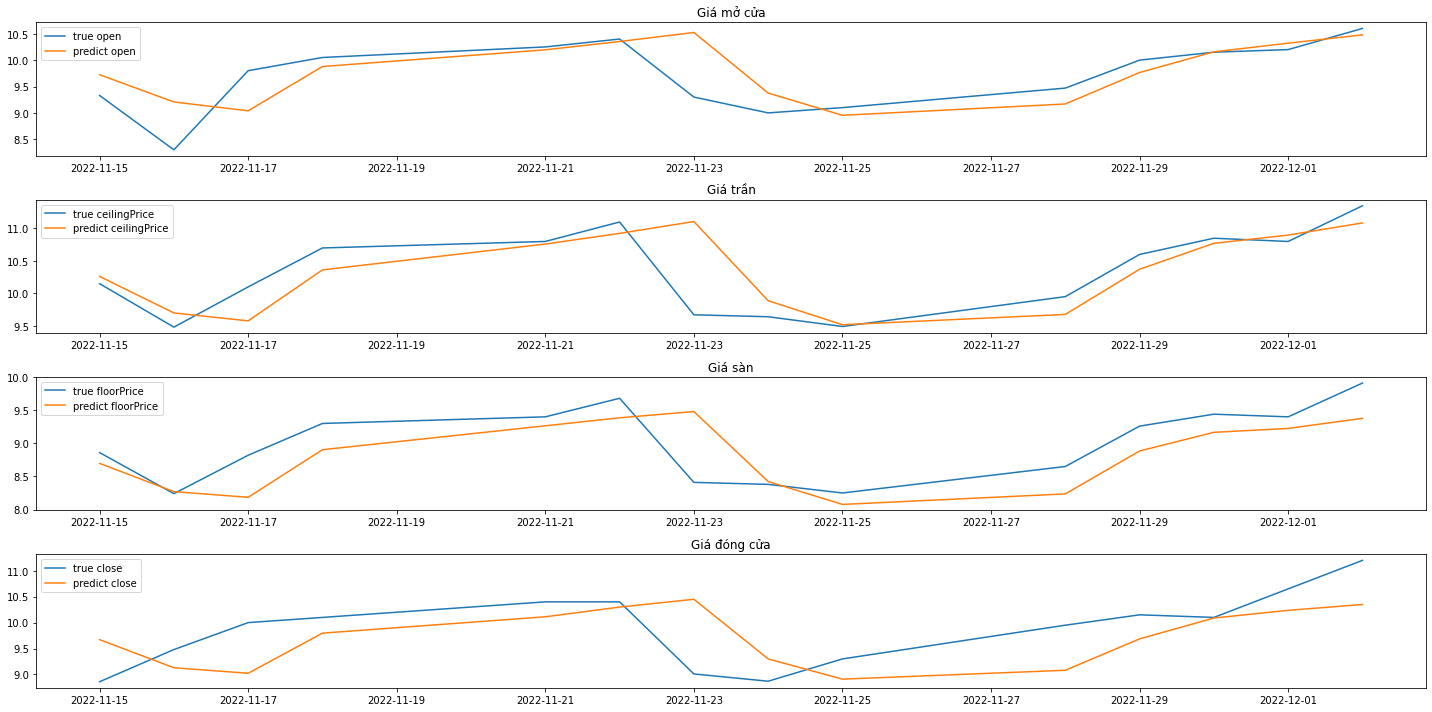

In [47]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe['date'][-(n_steps_in):] #Lấy cột date
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates, dataframe[feature][-(n_steps_in):]) #Vẽ dường thực tế
  axs[idx].plot(dates, test_predict[:,idx]) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

Dự đoán 14 ngày tiếp theo

In [48]:
predicts = list(dataframe[features[1:]][-14:].to_numpy()) #Lấy dữ liệu 14 ngày trước 

while(len(predicts) < 14+14): #Thực hiện vào lặp dự đoán 14 ngày tiếp theo
  X_predicts = np.array(predicts[-14:]) #Lấy 14 ngày trước từ mảng predicts
  X_predicts = X_predicts.reshape((1, n_input)) #Chuyển từ dạng (?, {n_steps_in}, 6) sang (?, {n_steps_in}*6)

  predict = model.predict(X_predicts, verbose=0) #Thực hiện dự đoán
  predicts.append(predict[0]) #Thêm dự đoán vào mảng predicts để tiếp tục dự đoán

predicts = np.array(predicts) #Chuyển predicts lại thành np array
predicts[-14:] #In dự đoán 14 ngày tiếp theo

array([[10.93299198, 11.60452652,  9.77229214, 10.84049511],
       [11.13456059, 11.77400017,  9.96136665, 10.98807812],
       [11.15641689, 11.82157993, 10.01837063, 10.97650909],
       [11.0507288 , 11.73468304,  9.93552113, 10.92298222],
       [11.12926102, 11.7776165 ,  9.96104717, 10.9704771 ],
       [11.02108097, 11.70335388,  9.84453201, 10.91135788],
       [11.05069065, 11.70536518,  9.82625675, 10.89067936],
       [11.02000904, 11.65783882,  9.82328892, 10.87410545],
       [10.99136734, 11.63879108,  9.79869747, 10.87476349],
       [11.04640484, 11.66663074,  9.85268307, 10.91900539],
       [11.08754826, 11.7008419 ,  9.91768456, 10.95789528],
       [11.09042072, 11.72015858,  9.94319439, 10.9949646 ],
       [11.1714716 , 11.78971672, 10.02249146, 11.05966091],
       [11.19293118, 11.81647968, 10.06639957, 11.08348751]])

Vẽ hình dự đoán 14 ngày tiếp theo

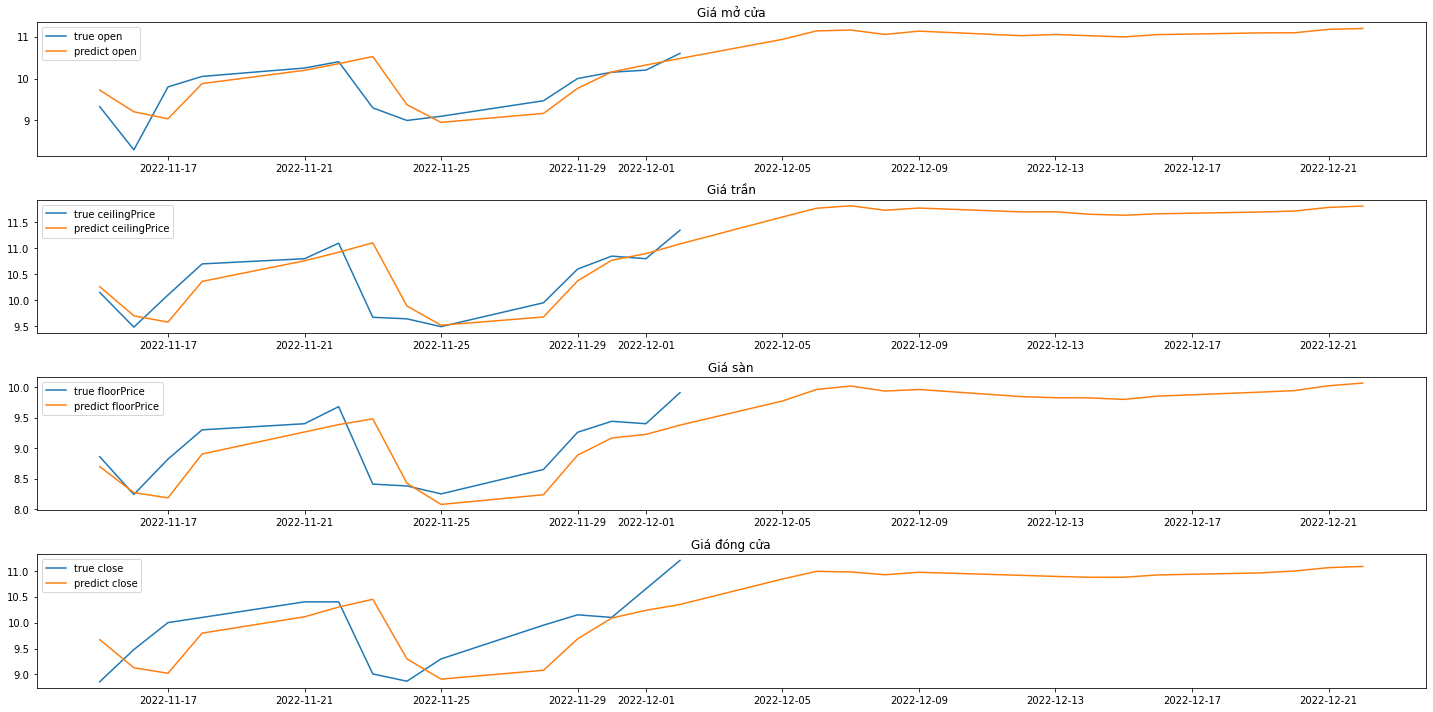

In [49]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe['date'][-(n_steps_in):] #Lấy cột date
dates = dates_add(dates, 14) #Thêm vào mảng date 14 ngày
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates[:14], predicts[:14,idx]) #Vẽ dường thực tế
  axs[idx].plot(dates, np.concatenate((test_predict[:,idx], predicts[14:,idx]))) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

## Dữ liệu theo tuần

### Mô hình RNN

Tiền xử lý

In [50]:
n_steps_in = 7 #Lấy {n_steps_in} ngày trước để dự đoán ngày hôm nay

dataset = dataframe_w[features[1:]].to_numpy() #Chuyển dataframe thành mảng
X, y = split_sequences(dataset, n_steps_in) #Chia dataset thành X và y theo {n_steps_in}

n_input = X.shape[1] * X.shape[2] #Tính chiều dài input
n_output = y.shape[1] * y.shape[2] #Tính chiều dài output

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=len(X)-n_steps_in,shuffle = False) #Chia dữ liệu tập train và test trong đó test chứa {n_steps_in} để thực hiện dự đoán

Xây dựng mô hình

In [51]:
model = Sequential() #Khởi tạo model
model.add(SimpleRNN(20,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))) #Thêm lớp SimpleRNN với regularizer
model.add(Dropout(0.1)) #Thêm lớp Drop Out
model.add(Dense(n_output)) #Thêm lớp Dense với n_output là số lượng tham số đầu ra
model.compile(optimizer='adam', loss='mae')

Thực hiện huấn luyện mô hình

In [52]:
callback = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True) #EarlyStop nếu 50 epoch không thay đổi loss trả về mô hình với loss thấp nhất

start_time = datetime.now() #Lưu thời gian bắt đầu train
model.fit(X_train, y_train, epochs=1000, shuffle=False, verbose=2, callbacks=[callback]) #Train mô hình
print(f"Thời gian train: {(datetime.now()-start_time).total_seconds()} giây") #In thời gian train

Epoch 1/1000
16/16 - 1s - loss: 10.6460 - 916ms/epoch - 57ms/step
Epoch 2/1000
16/16 - 0s - loss: 10.1184 - 98ms/epoch - 6ms/step
Epoch 3/1000
16/16 - 0s - loss: 9.6556 - 95ms/epoch - 6ms/step
Epoch 4/1000
16/16 - 0s - loss: 8.9949 - 111ms/epoch - 7ms/step
Epoch 5/1000
16/16 - 0s - loss: 8.4151 - 86ms/epoch - 5ms/step
Epoch 6/1000
16/16 - 0s - loss: 8.0289 - 93ms/epoch - 6ms/step
Epoch 7/1000
16/16 - 0s - loss: 7.6665 - 100ms/epoch - 6ms/step
Epoch 8/1000
16/16 - 0s - loss: 7.3517 - 94ms/epoch - 6ms/step
Epoch 9/1000
16/16 - 0s - loss: 7.0147 - 105ms/epoch - 7ms/step
Epoch 10/1000
16/16 - 0s - loss: 6.6468 - 99ms/epoch - 6ms/step
Epoch 11/1000
16/16 - 0s - loss: 6.3544 - 89ms/epoch - 6ms/step
Epoch 12/1000
16/16 - 0s - loss: 6.0462 - 90ms/epoch - 6ms/step
Epoch 13/1000
16/16 - 0s - loss: 5.7894 - 97ms/epoch - 6ms/step
Epoch 14/1000
16/16 - 0s - loss: 5.5422 - 109ms/epoch - 7ms/step
Epoch 15/1000
16/16 - 0s - loss: 5.3268 - 106ms/epoch - 7ms/step
Epoch 16/1000
16/16 - 0s - loss: 5.0765 

Dự đoán tập test

In [53]:
test_predict = model.predict(X_test, verbose=0) #Dự đoán tập test
test_predict #In dự đoán

array([[10.681291 , 11.6274805,  9.749107 , 10.695496 ],
       [11.231977 , 12.189251 , 10.297478 , 11.25727  ],
       [12.125513 , 13.144361 , 11.087702 , 12.136862 ],
       [11.500945 , 12.513729 , 10.5191   , 11.5167675],
       [10.19015  , 11.138669 ,  9.29555  , 10.207088 ],
       [ 9.838531 , 10.728065 ,  8.970521 ,  9.851427 ],
       [ 9.430457 , 10.314593 ,  8.575915 ,  9.444509 ]], dtype=float32)

Vẽ hình dự đoán theo tập test

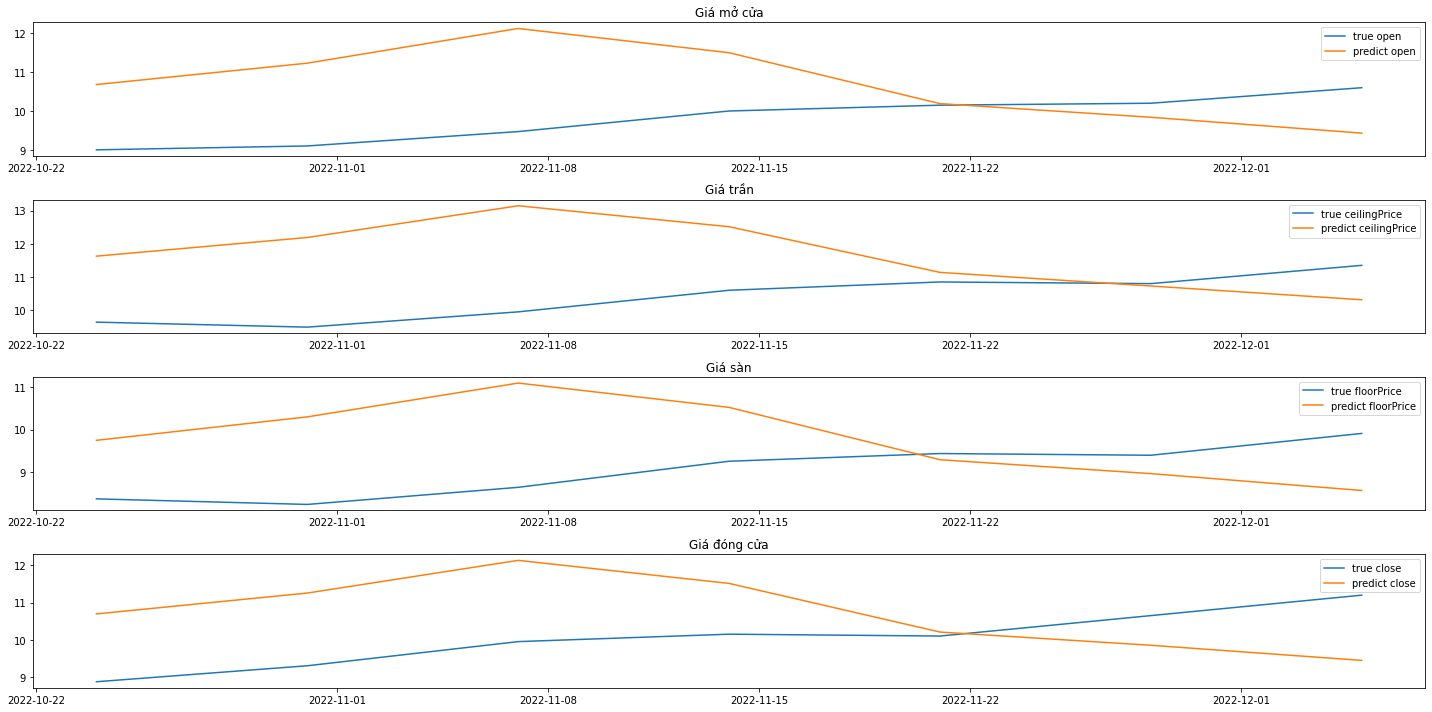

In [54]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe_w['date'][-(n_steps_in):] #Lấy cột date
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates, dataframe[feature][-(n_steps_in):]) #Vẽ dường thực tế
  axs[idx].plot(dates, test_predict[:,idx]) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

Dự đoán 7 tuần tiếp theo

In [55]:
predicts = list(dataframe[features[1:]][-7:].to_numpy()) #Lấy dữ liệu 7 tuần trước 

while(len(predicts) < 7+7): #Thực hiện vào lặp dự đoán 7 tuần tiếp theo
  X_predicts = np.array([predicts[-7:]]) #Lấy 7 tuần trước từ mảng predicts
  predict = model.predict(X_predicts, verbose=0) #Thực hiện dự đoán
  predicts.append(predict[0]) #Thêm dự đoán vào mảng predicts để tiếp tục dự đoán

predicts = np.array(predicts) #Chuyển predicts lại thành np array
predicts[-7:] #In dự đoán 7 tuần tiếp theo

array([[11.5091877 , 12.53714275, 10.49166679, 11.51459122],
       [11.17088318, 12.2296381 , 10.22160339, 11.18287277],
       [10.9849968 , 12.00857735, 10.06244373, 10.99784851],
       [10.95959949, 11.96953297, 10.04019737, 10.97306252],
       [11.06475544, 12.07443523, 10.13897324, 11.0782814 ],
       [11.2504015 , 12.27005386, 10.31069565, 11.26355839],
       [11.48420429, 12.51744461, 10.52814865, 11.49749184]])

Vẽ hình dự đoán 7 tuần tiếp theo

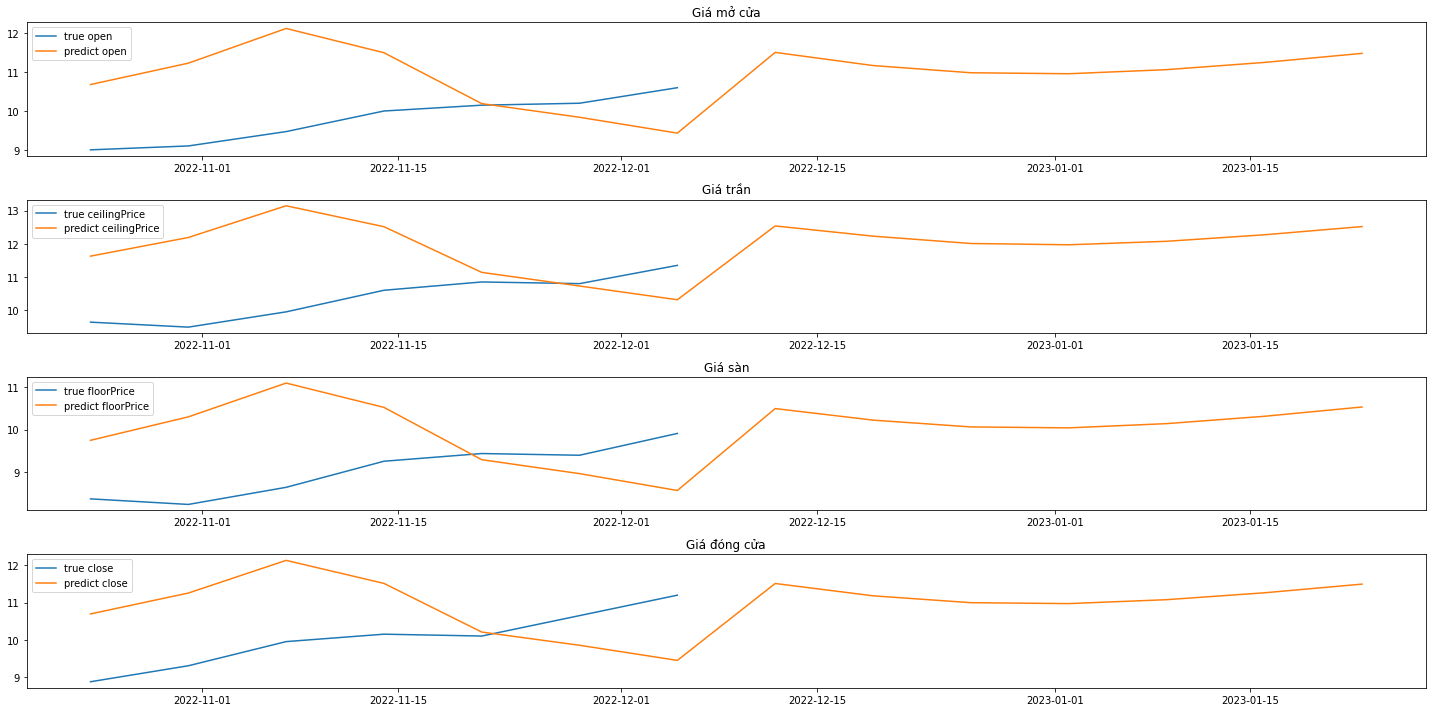

In [56]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe_w['date'][-(n_steps_in):] #Lấy cột date
dates = dates_add(dates, 7, distance=7) #Thêm vào mảng date 14 ngày
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates[:7], predicts[:7,idx]) #Vẽ dường thực tế
  axs[idx].plot(dates, np.concatenate((test_predict[:,idx], predicts[7:,idx]))) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

### Mô hình MLP

Tiền xử lý

In [57]:
n_steps_in = 7 #Lấy {n_steps_in} ngày trước để dự đoán ngày hôm nay

dataset = dataframe[features[1:]].to_numpy() #Chuyển dataframe thành mảng
X, y = split_sequences(dataset, n_steps_in) #Chia dataset thành X và y theo {n_steps_in}

n_input = X.shape[1] * X.shape[2] #Tính chiều dài input
X = X.reshape((X.shape[0], n_input)) #Chuyển X shape từ (?, 7, 4) thành (?, 28)
n_output = y.shape[1] * y.shape[2] #Tính chiều dài output
y = y.reshape((y.shape[0], n_output)) #Chuyển y shape từ (?, 7, 4) thành (?, 28)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=len(X)-n_steps_in,shuffle = False) #Chia dữ liệu tập train và test trong đó test chứa {n_steps_in} để thực hiện dự đoán

Xây dựng mô hình

In [58]:
model = Sequential() #Khởi tạo model
model.add(Dense(100, activation='relu', input_dim=n_input, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))) #Thêm lớp Dense với n_input là số lương tham số đầu vào và regularizer
model.add(Dropout(0.01)) #Thêm lớp Drop Out
model.add(Dense(n_output)) #Thêm lớp Dense với n_output là số lượng tham số đầu ra
model.compile(optimizer='adam', loss='mse')

Thực hiện huấn luyện mô hình

In [59]:
callback = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True) #EarlyStop nếu 50 epoch không thay đổi loss trả về mô hình với loss thấp nhất

start_time = datetime.now() #Lưu thời gian bắt đầu train
model.fit(X_train, y_train, epochs=1000, shuffle=False, verbose=2, callbacks=[callback]) #Train mô hình
print(f"Thời gian train: {(datetime.now()-start_time).total_seconds()} giây") #In ra thời gian train

Epoch 1/1000
77/77 - 1s - loss: 11.4167 - 517ms/epoch - 7ms/step
Epoch 2/1000
77/77 - 0s - loss: 1.4582 - 157ms/epoch - 2ms/step
Epoch 3/1000
77/77 - 0s - loss: 1.3743 - 158ms/epoch - 2ms/step
Epoch 4/1000
77/77 - 0s - loss: 1.2767 - 153ms/epoch - 2ms/step
Epoch 5/1000
77/77 - 0s - loss: 1.1474 - 152ms/epoch - 2ms/step
Epoch 6/1000
77/77 - 0s - loss: 1.0893 - 150ms/epoch - 2ms/step
Epoch 7/1000
77/77 - 0s - loss: 0.9202 - 158ms/epoch - 2ms/step
Epoch 8/1000
77/77 - 0s - loss: 0.8464 - 158ms/epoch - 2ms/step
Epoch 9/1000
77/77 - 0s - loss: 0.9086 - 153ms/epoch - 2ms/step
Epoch 10/1000
77/77 - 0s - loss: 0.8099 - 171ms/epoch - 2ms/step
Epoch 11/1000
77/77 - 0s - loss: 0.7735 - 157ms/epoch - 2ms/step
Epoch 12/1000
77/77 - 0s - loss: 0.7127 - 153ms/epoch - 2ms/step
Epoch 13/1000
77/77 - 0s - loss: 0.7065 - 157ms/epoch - 2ms/step
Epoch 14/1000
77/77 - 0s - loss: 0.7098 - 149ms/epoch - 2ms/step
Epoch 15/1000
77/77 - 0s - loss: 0.7174 - 152ms/epoch - 2ms/step
Epoch 16/1000
77/77 - 0s - loss: 

Dự đoán tập test

In [60]:
test_predict = model.predict(X_test, verbose=0)
test_predict

array([[ 9.0365505,  9.94489  ,  7.9755454,  8.986079 ],
       [ 8.854986 ,  9.724676 ,  7.811772 ,  8.827329 ],
       [ 9.10395  , 10.028252 ,  8.0861225,  9.136064 ],
       [ 9.766203 , 10.779731 ,  8.697145 ,  9.851571 ],
       [10.111127 , 11.248506 ,  9.078329 , 10.240092 ],
       [10.083121 , 11.196698 ,  9.010389 , 10.137545 ],
       [10.426244 , 11.522723 ,  9.284594 , 10.42793  ]], dtype=float32)

Vẽ hình dự đoán theo tập test

In [61]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe_w['date'][-(n_steps_in):] #Lấy cột date
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates, dataframe[feature][-(n_steps_in):]) #Vẽ dường thực tế
  axs[idx].plot(dates, test_predict[:,idx]) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

Dự đoán 7 tuần tiếp theo

In [62]:
predicts = list(dataframe[features[1:]][-7:].to_numpy()) #Lấy dữ liệu 7 tuần trước 

while(len(predicts) < 7+7): #Thực hiện vào lặp dự đoán 7 tuần tiếp theo
  X_predicts = np.array(predicts[-7:]) #Lấy 7 tuần trước từ mảng predicts
  X_predicts = X_predicts.reshape((1, n_input)) #Chuyển từ dạng (?, {n_steps_in}, 6) sang (?, {n_steps_in}*6)

  predict = model.predict(X_predicts, verbose=0) #Thực hiện dự đoán
  predicts.append(predict[0]) #Thêm dự đoán vào mảng predicts để tiếp tục dự đoán

predicts = np.array(predicts) #Chuyển predicts lại thành np array
predicts[-7:] #In dự đoán 7 tuần tiếp theo

array([[10.96449471, 12.10379505,  9.76080132, 10.95069408],
       [10.94195175, 12.08085346,  9.73133087, 10.92952633],
       [10.94500732, 12.0758276 ,  9.74639893, 10.94388103],
       [10.89266396, 11.99706936,  9.69265556, 10.88958168],
       [10.8499012 , 11.93257999,  9.63423157, 10.84782028],
       [10.88161945, 11.97887707,  9.67682457, 10.91953564],
       [10.94381905, 12.06081486,  9.74632263, 11.00052452]])

Vẽ hình dự đoán 7 tuần tiếp theo

In [63]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe_w['date'][-(n_steps_in):] #Lấy cột date
dates = dates_add(dates, 7, distance=7) #Thêm vào mảng date 7 tuần
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates[:7], predicts[:7,idx]) #Vẽ dường thực tế
  axs[idx].plot(dates, np.concatenate((test_predict[:,idx], predicts[7:,idx]))) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

# Câu 5: Tìm feature quan trọng

## Hàm sử dụng

In [64]:
def MLP(chose_features, n_steps_in):
  dataset = dataframe[chose_features].to_numpy() #Chuyển dataframe thành mảng
  X, y = split_sequences(dataset, n_steps_in) #Chia dataset thành X và y theo {n_steps_in}

  n_input = X.shape[1] * X.shape[2] #Tính chiều dài input
  X = X.reshape((X.shape[0], n_input)) #Chuyển X shape từ (?, {n_steps_in}, {len(chose_features)}) thành (?, {n_steps_in}*{len(chose_features)})
  n_output = y.shape[1] * y.shape[2] #Tính chiều dài output
  y = y.reshape((y.shape[0], n_output)) #Chuyển y shape từ (?, {n_steps_in}, {len(chose_features)}) thành (?, {n_steps_in}*{len(chose_features)})

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=len(X)-n_steps_in,shuffle = False) #Chia dữ liệu tập train và test trong đó test chứa {n_steps_in} để thực hiện dự đoán

  model = Sequential() #Khởi tạo model
  model.add(Dense(100, activation='relu', input_dim=n_input, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))) #Thêm lớp Dense với n_input là số lương tham số đầu vào và regularizer
  model.add(Dropout(0.01)) #Thêm lớp Drop Out
  model.add(Dense(n_output)) #Thêm lớp Dense với n_output là số lượng tham số đầu ra
  model.compile(optimizer='adam', loss='mse')

  callback = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True) #EarlyStop nếu 50 epoch không thay đổi loss trả về mô hình với loss thấp nhất

  start_time = datetime.now() #Lưu thời gian bắt đầu train
  model.fit(X_train, y_train, epochs=1000, shuffle=False, verbose=2, callbacks=[callback]) #Train mô hình
  print(f"Thời gian train: {(datetime.now()-start_time).total_seconds()} giây") #In thời gian train
  return model, X_test

def PredictNDrawGraph(model, chose_features, n_steps_in, X_test):
  test_predict = model.predict(X_test, verbose=0) #Dự đoán tập test
  predicts = list(dataframe[chose_features][-n_steps_in:].to_numpy()) #Lấy dữ liệu {n_steps_in} ngày trước 

  while(len(predicts) < n_steps_in*2): #Thực hiện vào lặp dự đoán {n_steps_in} ngàytiếp theo
    X_predicts = np.array(predicts[-n_steps_in:]) #Lấy {n_steps_in} ngày trước từ mảng predicts
    X_predicts = X_predicts.reshape((1, len(chose_features)*n_steps_in)) #Chuyển từ dạng (?, {n_steps_in}, {len(chose_features)}) sang (?, {n_steps_in}*{len(chose_features)})

    predict = model.predict(X_predicts, verbose=0) #Thực hiện dự đoán
    predicts.append(predict[0]) #Thêm dự đoán vào mảng predicts để tiếp tục dự đoán

  predicts = np.array(predicts) #Chuyển predicts lại thành np array

  fig, axs = plt.subplots(len(chose_features), 1, squeeze=False, figsize = (20,10)) #Tạo plot
  axs = axs.reshape((len(chose_features),))

  dates = dataframe['date'][-(n_steps_in):] #Lấy cột date
  dates = dates_add(dates, n_steps_in) #Thêm vào mảng date
  titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề
  chose_titles = [titles[features[1:].index(chose_feature)] for chose_feature in chose_features]

  for idx, feature in enumerate(chose_features): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
    axs[idx].plot(dates[:n_steps_in], predicts[:n_steps_in,idx]) #Vẽ dường thực tế
    axs[idx].plot(dates, np.concatenate((test_predict[:,idx], predicts[n_steps_in:,idx]))) #Vẽ đường dự đoán
    axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
    axs[idx].set_title(chose_titles[idx]) #Tạo tiêu đề

  plt.tight_layout() #Giảm lề
  plt.show() #In hình

## Tập close

In [65]:
chose_features = ['close'] #Chọn 2 feature clsóe
n_steps_in = 14 #Số ngày trước để dự đoán hôm sau

model, X_test = MLP(chose_features, n_steps_in) #Train mô hình và trả về tập test

Epoch 1/1000
77/77 - 1s - loss: 3.0384 - 519ms/epoch - 7ms/step
Epoch 2/1000
77/77 - 0s - loss: 1.2249 - 163ms/epoch - 2ms/step
Epoch 3/1000
77/77 - 0s - loss: 1.0885 - 150ms/epoch - 2ms/step
Epoch 4/1000
77/77 - 0s - loss: 1.1139 - 151ms/epoch - 2ms/step
Epoch 5/1000
77/77 - 0s - loss: 1.0088 - 151ms/epoch - 2ms/step
Epoch 6/1000
77/77 - 0s - loss: 0.9494 - 152ms/epoch - 2ms/step
Epoch 7/1000
77/77 - 0s - loss: 0.9044 - 165ms/epoch - 2ms/step
Epoch 8/1000
77/77 - 0s - loss: 0.8242 - 151ms/epoch - 2ms/step
Epoch 9/1000
77/77 - 0s - loss: 0.7478 - 154ms/epoch - 2ms/step
Epoch 10/1000
77/77 - 0s - loss: 0.7540 - 149ms/epoch - 2ms/step
Epoch 11/1000
77/77 - 0s - loss: 0.7094 - 148ms/epoch - 2ms/step
Epoch 12/1000
77/77 - 0s - loss: 0.7005 - 152ms/epoch - 2ms/step
Epoch 13/1000
77/77 - 0s - loss: 0.6445 - 164ms/epoch - 2ms/step
Epoch 14/1000
77/77 - 0s - loss: 0.6002 - 155ms/epoch - 2ms/step
Epoch 15/1000
77/77 - 0s - loss: 0.5748 - 153ms/epoch - 2ms/step
Epoch 16/1000
77/77 - 0s - loss: 0

In [66]:
PredictNDrawGraph(model, chose_features, n_steps_in, X_test) #Vẽ hình dự đoán 14 ngày tiếp theo

## Tập open, close

In [67]:
chose_features = ['open', 'close'] #Chọn 2 feature là open và close
n_steps_in = 14 #Số ngày trước để dự đoán hôm sau

model, X_test = MLP(chose_features, n_steps_in) #Train mô hình và trả về tập test

Epoch 1/1000
77/77 - 1s - loss: 7.5731 - 533ms/epoch - 7ms/step
Epoch 2/1000
77/77 - 0s - loss: 1.7337 - 154ms/epoch - 2ms/step
Epoch 3/1000
77/77 - 0s - loss: 1.4839 - 164ms/epoch - 2ms/step
Epoch 4/1000
77/77 - 0s - loss: 1.2222 - 166ms/epoch - 2ms/step
Epoch 5/1000
77/77 - 0s - loss: 1.2246 - 149ms/epoch - 2ms/step
Epoch 6/1000
77/77 - 0s - loss: 1.0758 - 174ms/epoch - 2ms/step
Epoch 7/1000
77/77 - 0s - loss: 1.0263 - 153ms/epoch - 2ms/step
Epoch 8/1000
77/77 - 0s - loss: 0.9209 - 150ms/epoch - 2ms/step
Epoch 9/1000
77/77 - 0s - loss: 0.9283 - 149ms/epoch - 2ms/step
Epoch 10/1000
77/77 - 0s - loss: 0.8234 - 185ms/epoch - 2ms/step
Epoch 11/1000
77/77 - 0s - loss: 0.7923 - 150ms/epoch - 2ms/step
Epoch 12/1000
77/77 - 0s - loss: 0.7971 - 148ms/epoch - 2ms/step
Epoch 13/1000
77/77 - 0s - loss: 0.6958 - 156ms/epoch - 2ms/step
Epoch 14/1000
77/77 - 0s - loss: 0.7319 - 149ms/epoch - 2ms/step
Epoch 15/1000
77/77 - 0s - loss: 0.6652 - 146ms/epoch - 2ms/step
Epoch 16/1000
77/77 - 0s - loss: 0

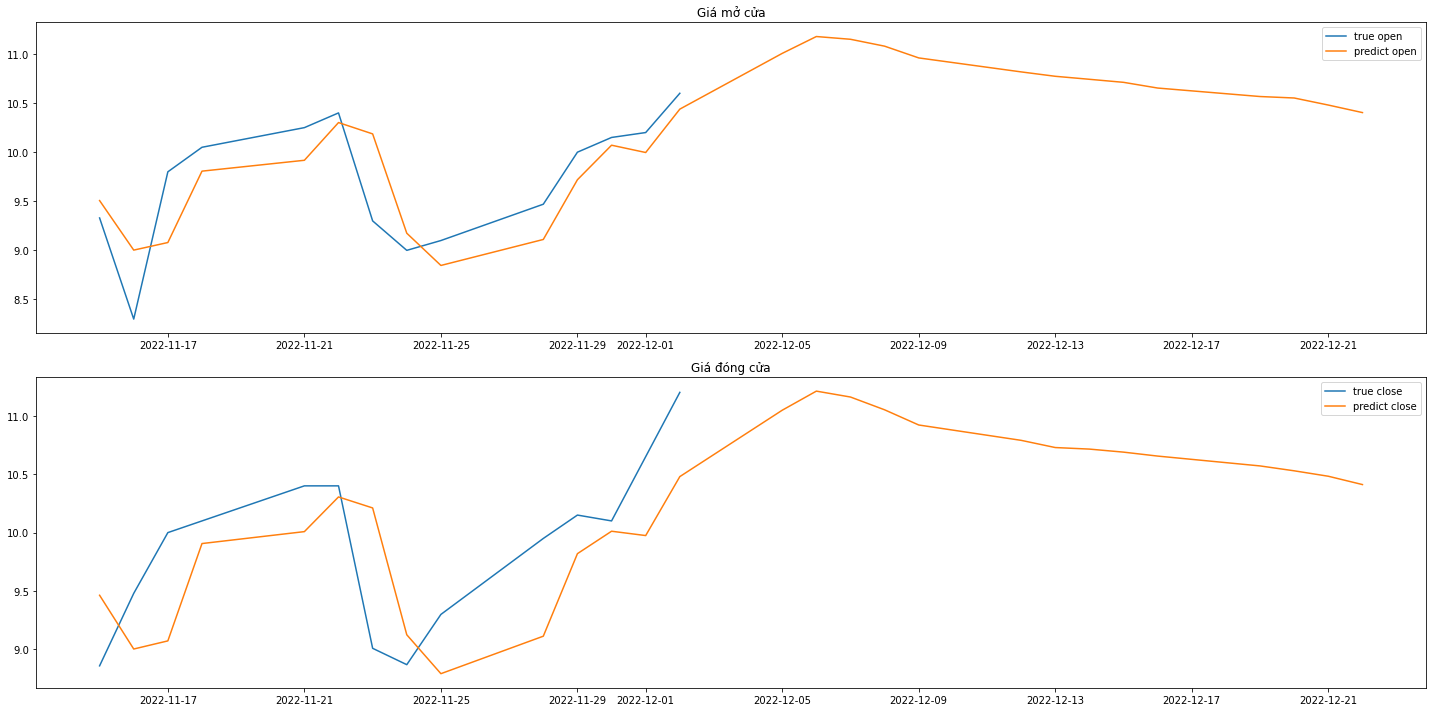

In [68]:
PredictNDrawGraph(model, chose_features, n_steps_in, X_test) #Vẽ hình dự đoán 14 ngày tiếp theo

## Tập ceilingPrice, floorPrice, close

In [69]:
chose_features = ['ceilingPrice', 'floorPrice', 'close'] #Chọn 2 feature là ceilingPrice, floorPrice và close
n_steps_in = 14 #Số ngày trước để dự đoán hôm sau

model, X_test = MLP(chose_features, n_steps_in) #Train mô hình và trả về tập test

Epoch 1/1000
77/77 - 0s - loss: 5.2737 - 496ms/epoch - 6ms/step
Epoch 2/1000
77/77 - 0s - loss: 2.0046 - 157ms/epoch - 2ms/step
Epoch 3/1000
77/77 - 0s - loss: 1.8301 - 159ms/epoch - 2ms/step
Epoch 4/1000
77/77 - 0s - loss: 1.7417 - 160ms/epoch - 2ms/step
Epoch 5/1000
77/77 - 0s - loss: 1.4703 - 162ms/epoch - 2ms/step
Epoch 6/1000
77/77 - 0s - loss: 1.3589 - 159ms/epoch - 2ms/step
Epoch 7/1000
77/77 - 0s - loss: 1.2017 - 165ms/epoch - 2ms/step
Epoch 8/1000
77/77 - 0s - loss: 1.1318 - 159ms/epoch - 2ms/step
Epoch 9/1000
77/77 - 0s - loss: 1.1268 - 156ms/epoch - 2ms/step
Epoch 10/1000
77/77 - 0s - loss: 1.1068 - 165ms/epoch - 2ms/step
Epoch 11/1000
77/77 - 0s - loss: 1.0238 - 158ms/epoch - 2ms/step
Epoch 12/1000
77/77 - 0s - loss: 1.0231 - 166ms/epoch - 2ms/step
Epoch 13/1000
77/77 - 0s - loss: 0.9698 - 164ms/epoch - 2ms/step
Epoch 14/1000
77/77 - 0s - loss: 0.9464 - 158ms/epoch - 2ms/step
Epoch 15/1000
77/77 - 0s - loss: 0.8791 - 162ms/epoch - 2ms/step
Epoch 16/1000
77/77 - 0s - loss: 0

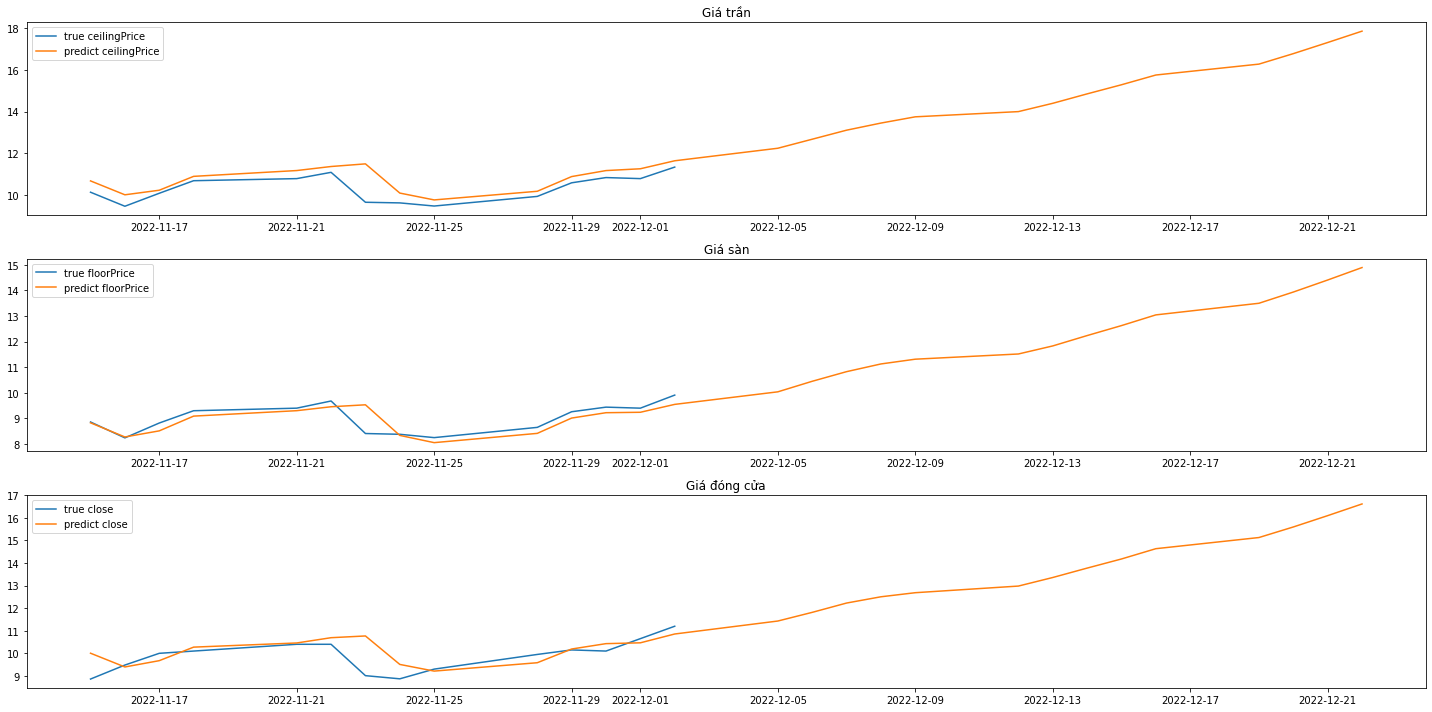

In [70]:
PredictNDrawGraph(model, chose_features, n_steps_in, X_test) #Vẽ hình dự đoán 14 ngày tiếp theo

#Câu 6: Mô hình LSTM

## Dữ liệu theo ngày

Tiền xử lý

In [71]:
n_steps_in = 14 #Lấy {n_steps_in} ngày trước để dự đoán ngày hôm nay

dataset = dataframe[features[1:]].to_numpy() #Chuyển dataframe thành mảng
X, y = split_sequences(dataset, n_steps_in) #Chia dataset thành X và y theo {n_steps_in}

n_input = X.shape[1] * X.shape[2] #Tính chiều dài input
n_output = y.shape[1] * y.shape[2] #Tính chiều dài output

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=len(X)-n_steps_in,shuffle = False) #Chia dữ liệu tập train và test trong đó test chứa {n_steps_in} để thực hiện dự đoán

Xây dựng mô hình

In [72]:
model = Sequential() #Khởi tạo model
model.add(LSTM(4, input_shape=(14, 4,),kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))) #Thêm lớp LSTM với regularizer
model.add(Dropout(0.1)) #Thêm lớp Drop Out
model.add(Dense(n_output)) #Thêm lớp Dense với n_output là số lượng tham số đầu ra
model.compile(optimizer='adam', loss='mae')

Thực hiện huấn luyện mô hình

In [73]:
callback = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True) #EarlyStop nếu 50 epoch không thay đổi loss trả về mô hình với loss thấp nhất

start_time = datetime.now() #Lưu thời gian bắt đầu train
model.fit(X_train, y_train, epochs=1000, shuffle=False, verbose=2, callbacks=[callback]) #Train mô hình
print(f"Thời gian train: {(datetime.now()-start_time).total_seconds()} giây") #In thời gian train

Epoch 1/1000
77/77 - 5s - loss: 10.6335 - 5s/epoch - 59ms/step
Epoch 2/1000
77/77 - 0s - loss: 10.2860 - 250ms/epoch - 3ms/step
Epoch 3/1000
77/77 - 0s - loss: 9.7591 - 261ms/epoch - 3ms/step
Epoch 4/1000
77/77 - 0s - loss: 9.3054 - 252ms/epoch - 3ms/step
Epoch 5/1000
77/77 - 0s - loss: 8.9212 - 255ms/epoch - 3ms/step
Epoch 6/1000
77/77 - 0s - loss: 8.5460 - 250ms/epoch - 3ms/step
Epoch 7/1000
77/77 - 0s - loss: 7.7988 - 255ms/epoch - 3ms/step
Epoch 8/1000
77/77 - 0s - loss: 7.2507 - 258ms/epoch - 3ms/step
Epoch 9/1000
77/77 - 0s - loss: 6.8184 - 264ms/epoch - 3ms/step
Epoch 10/1000
77/77 - 0s - loss: 6.4295 - 247ms/epoch - 3ms/step
Epoch 11/1000
77/77 - 0s - loss: 6.0463 - 257ms/epoch - 3ms/step
Epoch 12/1000
77/77 - 0s - loss: 5.7664 - 249ms/epoch - 3ms/step
Epoch 13/1000
77/77 - 0s - loss: 5.4522 - 252ms/epoch - 3ms/step
Epoch 14/1000
77/77 - 0s - loss: 5.2485 - 267ms/epoch - 3ms/step
Epoch 15/1000
77/77 - 0s - loss: 4.9959 - 257ms/epoch - 3ms/step
Epoch 16/1000
77/77 - 0s - loss: 4

Dự đoán tập test

In [74]:
test_predict = model.predict(X_test, verbose=0) #Dự đoán tập test
test_predict #In dự đoán

array([[ 9.330021 , 10.146001 ,  8.556483 ,  9.3257   ],
       [ 8.714754 ,  9.482364 ,  7.9893827,  8.712461 ],
       [ 8.834073 ,  9.6133   ,  8.0856   ,  8.830717 ],
       [ 9.323616 , 10.134117 ,  8.53506  ,  9.314203 ],
       [ 9.613493 , 10.444953 ,  8.802962 ,  9.602471 ],
       [ 9.894475 , 10.749501 ,  9.059564 ,  9.883407 ],
       [ 9.943575 , 10.804743 ,  9.106094 ,  9.934291 ],
       [ 8.884167 ,  9.672703 ,  8.127565 ,  8.885426 ],
       [ 8.473063 ,  9.225182 ,  7.752289 ,  8.473497 ],
       [ 8.699138 ,  9.462532 ,  7.9584155,  8.69411  ],
       [ 9.255459 , 10.059004 ,  8.46701  ,  9.2456665],
       [ 9.568172 , 10.395895 ,  8.756215 ,  9.5574665],
       [ 9.65794  , 10.494025 ,  8.841465 ,  9.648274 ],
       [10.025467 , 10.893214 ,  9.17552  , 10.01553  ]], dtype=float32)

Vẽ hình dự đoán theo tập test

In [75]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe['date'][-(n_steps_in):] #Lấy cột date
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates, dataframe[feature][-(n_steps_in):]) #Vẽ dường thực tế
  axs[idx].plot(dates, test_predict[:,idx]) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

Dự đoán 14 ngày tiếp theo

In [76]:
predicts = list(dataframe[features[1:]][-14:].to_numpy()) #Lấy dữ liệu 14 ngày trước 

while(len(predicts) < 14+14): #Thực hiện vào lặp dự đoán 14 ngày tiếp theo
  X_predicts = np.array([predicts[-14:]]) #Lấy 14 ngày trước từ mảng predicts
  predict = model.predict(X_predicts, verbose=0) #Thực hiện dự đoán
  predicts.append(predict[0]) #Thêm dự đoán vào mảng predicts để tiếp tục dự đoán

predicts = np.array(predicts) #Chuyển predicts lại thành np array
predicts[-14:] #In dự đoán 14 ngày tiếp theo

array([[10.46854973, 11.3739996 ,  9.58091545, 10.45849895],
       [10.31402683, 11.21102238,  9.44127083, 10.30748463],
       [10.13786507, 11.02259731,  9.28144264, 10.13330078],
       [ 9.94983864, 10.82000351,  9.11003304,  9.94620037],
       [ 9.76137543, 10.61611938,  8.9375782 ,  9.75801849],
       [ 9.57917023, 10.41854382,  8.7703476 ,  9.57572746],
       [ 9.40604401, 10.23056412,  8.61103249,  9.4023428 ],
       [ 9.24332714, 10.05377579,  8.46100998,  9.23930359],
       [ 9.09063339,  9.8878355 ,  8.31998062,  9.08629227],
       [ 8.94750023,  9.73228931,  8.18760967,  8.94287586],
       [ 8.81301498,  9.58616924,  8.06310272,  8.80815887],
       [ 8.68629837,  9.44852638,  7.94568491,  8.68126297],
       [ 8.56691742,  9.31889343,  7.83501148,  8.5617485 ],
       [ 8.45479393,  9.19717407,  7.73105097,  8.44952106]])

Vẽ hình dự đoán 14 ngày tiếp theo

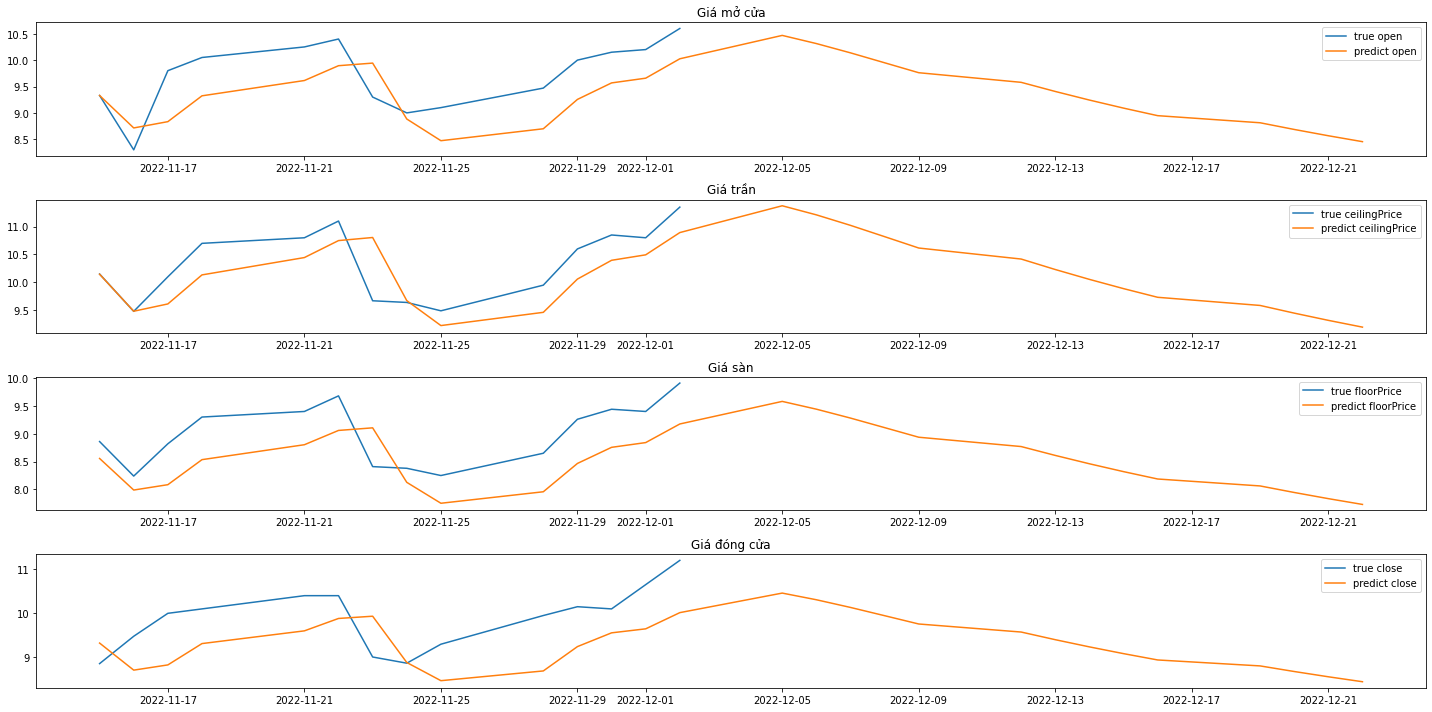

In [77]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe['date'][-(n_steps_in):] #Lấy cột date
dates = dates_add(dates, 14) #Thêm vào mảng date 14 ngày
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates[:14], predicts[:14,idx]) #Vẽ dường thực tế
  axs[idx].plot(dates, np.concatenate((test_predict[:,idx], predicts[14:,idx]))) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

## Dữ liệu theo tuần

Tiền xử lý

In [78]:
n_steps_in = 28 #Lấy {n_steps_in} ngày trước để dự đoán ngày hôm nay

dataset = dataframe_w[features[1:]].to_numpy() #Chuyển dataframe thành mảng
X, y = split_sequences(dataset, n_steps_in) #Chia dataset thành X và y theo {n_steps_in}

n_input = X.shape[1] * X.shape[2] #Tính chiều dài input
n_output = y.shape[1] * y.shape[2] #Tính chiều dài output

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=len(X)-7,shuffle = False) #Chia dữ liệu tập train và test trong đó test chứa {n_steps_in} để thực hiện dự đoán

Xây dựng mô hình

In [79]:
model = Sequential() #Khởi tạo model
model.add(LSTM(20,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))) #Thêm lớp LSTM với regularizer
model.add(Dropout(0.1)) #Thêm lớp Drop Out
model.add(Dense(n_output)) #Thêm lớp Dense với n_output là số lượng tham số đầu ra
model.compile(optimizer='adam', loss='mae')

Thực hiện huấn luyện mô hình

In [80]:
callback = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True) #EarlyStop nếu 50 epoch không thay đổi loss trả về mô hình với loss thấp nhất

start_time = datetime.now() #Lưu thời gian bắt đầu train
model.fit(X_train, y_train, epochs=1000, shuffle=False, verbose=2, callbacks=[callback]) #Train mô hình
print(f"Thời gian train: {(datetime.now()-start_time).total_seconds()} giây") #In thời gian train

Epoch 1/1000
16/16 - 2s - loss: 11.3244 - 2s/epoch - 115ms/step
Epoch 2/1000
16/16 - 0s - loss: 10.9989 - 68ms/epoch - 4ms/step
Epoch 3/1000
16/16 - 0s - loss: 10.5995 - 60ms/epoch - 4ms/step
Epoch 4/1000
16/16 - 0s - loss: 10.0580 - 62ms/epoch - 4ms/step
Epoch 5/1000
16/16 - 0s - loss: 9.4487 - 63ms/epoch - 4ms/step
Epoch 6/1000
16/16 - 0s - loss: 8.7355 - 62ms/epoch - 4ms/step
Epoch 7/1000
16/16 - 0s - loss: 8.0726 - 62ms/epoch - 4ms/step
Epoch 8/1000
16/16 - 0s - loss: 7.4266 - 60ms/epoch - 4ms/step
Epoch 9/1000
16/16 - 0s - loss: 6.8623 - 74ms/epoch - 5ms/step
Epoch 10/1000
16/16 - 0s - loss: 6.3372 - 62ms/epoch - 4ms/step
Epoch 11/1000
16/16 - 0s - loss: 5.9518 - 60ms/epoch - 4ms/step
Epoch 12/1000
16/16 - 0s - loss: 5.5984 - 63ms/epoch - 4ms/step
Epoch 13/1000
16/16 - 0s - loss: 5.3018 - 61ms/epoch - 4ms/step
Epoch 14/1000
16/16 - 0s - loss: 5.1069 - 62ms/epoch - 4ms/step
Epoch 15/1000
16/16 - 0s - loss: 4.8585 - 70ms/epoch - 4ms/step
Epoch 16/1000
16/16 - 0s - loss: 4.6355 - 60m

Dự đoán tập test

In [81]:
test_predict = model.predict(X_test, verbose=0) #Dự đoán tập test
test_predict #In dự đoán

array([[10.554324 , 11.54815  ,  9.493901 , 10.528373 ],
       [10.740494 , 11.723297 ,  9.67238  , 10.704869 ],
       [10.768596 , 11.7282   ,  9.704264 , 10.700645 ],
       [11.032645 , 12.003656 ,  9.93885  , 10.969791 ],
       [10.448374 , 11.38802  ,  9.393844 , 10.400952 ],
       [ 9.728357 , 10.6265545,  8.738116 ,  9.686027 ],
       [ 9.468303 , 10.33439  ,  8.502606 ,  9.410373 ]], dtype=float32)

Vẽ hình dự đoán theo tập test

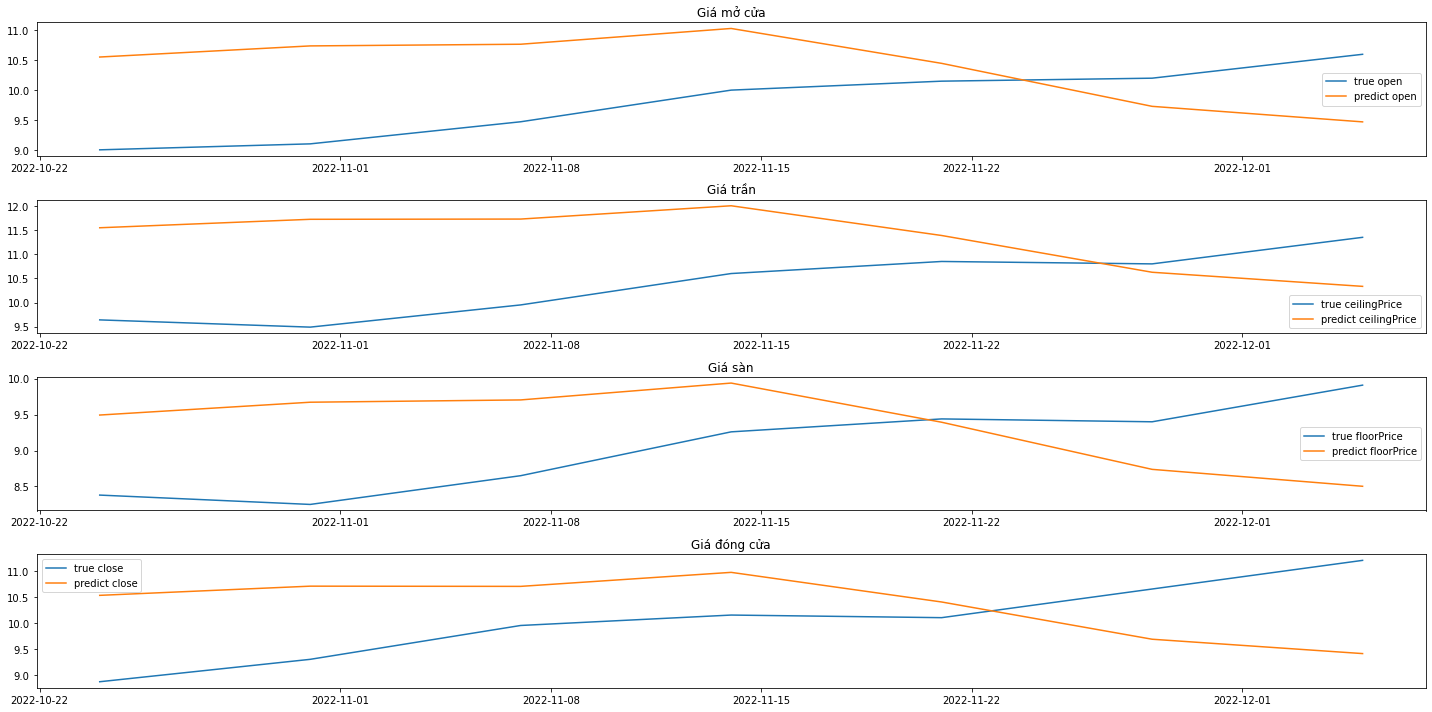

In [82]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe_w['date'][-(7):] #Lấy cột date
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates, dataframe[feature][-(7):]) #Vẽ dường thực tế
  axs[idx].plot(dates, test_predict[:,idx]) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình

Dự đoán 7 tuần tiếp theo

In [83]:
predicts = list(dataframe[features[1:]][-7:].to_numpy()) #Lấy dữ liệu 7 tuần trước 

while(len(predicts) < 7+7): #Thực hiện vào lặp dự đoán 7 tuần tiếp theo
  X_predicts = np.array([predicts[-7:]]) #Lấy 7 tuần trước từ mảng predicts
  predict = model.predict(X_predicts, verbose=0) #Thực hiện dự đoán
  predicts.append(predict[0]) #Thêm dự đoán vào mảng predicts để tiếp tục dự đoán

predicts = np.array(predicts) #Chuyển predicts lại thành np array
predicts[-7:] #In dự đoán 7 tuần tiếp theo

array([[10.89793396, 11.75676155,  9.76973534, 10.78610992],
       [10.96971321, 11.82983875,  9.82743931, 10.86040211],
       [11.08700085, 11.95416164,  9.93125343, 10.98086929],
       [11.23452568, 12.10920334, 10.06464863, 11.12919331],
       [11.4041996 , 12.28568363, 10.21760273, 11.29672241],
       [11.58928013, 12.47895908, 10.38461876, 11.47920132],
       [11.78858376, 12.68946362, 10.56631279, 11.67770386]])

Vẽ hình dự đoán 7 tuần tiếp theo

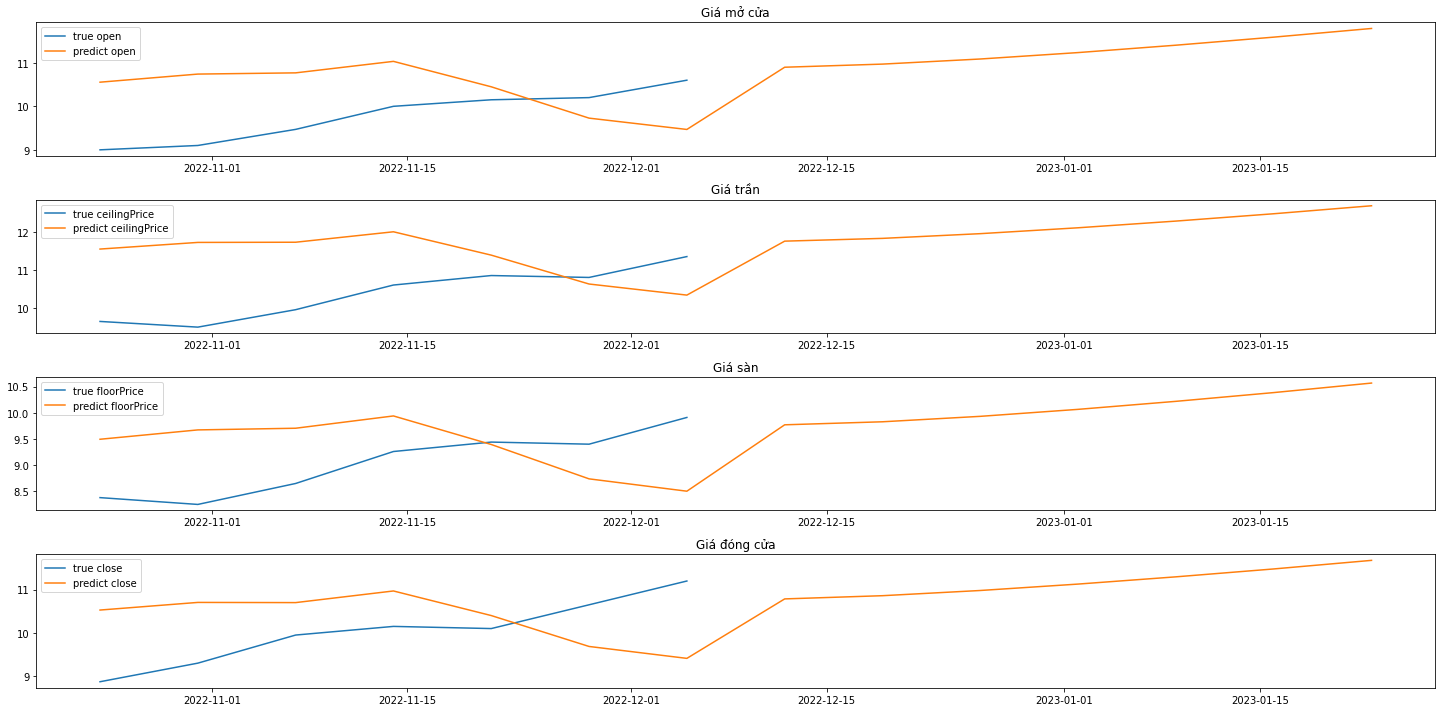

In [84]:
fig, axs = plt.subplots(4,figsize = (20,10)) #Tạo plot

dates = dataframe_w['date'][-7:] #Lấy cột date
dates = dates_add(dates, 7, distance=7) #Thêm vào mảng date 14 ngày
titles = ['Giá mở cửa', 'Giá trần', 'Giá sàn', 'Giá đóng cửa'] #Khai báo mảng tiêu đề

for idx, feature in enumerate(features[1:]): #Lặp vẽ 4 tương ứng với các feature được chọn trừ date
  axs[idx].plot(dates[:7], predicts[:7,idx]) #Vẽ dường thực tế
  axs[idx].plot(dates, np.concatenate((test_predict[:,idx], predicts[7:,idx]))) #Vẽ đường dự đoán
  axs[idx].legend([f'true {feature}', f'predict {feature}']) #Tạo chú thích
  axs[idx].set_title(titles[idx]) #Tạo tiêu đề

plt.tight_layout() #Giảm lề
plt.show() #In hình